# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 10000

In [10]:
#start_row = int(800000-(dev_data_size/2))-1
#finish_row = int(800000+(dev_data_size/2))-1
#df_sm = df[start_row:finish_row]
df_sm=df.sample(n=dev_data_size,replace=True)
df_sm.count()

sentiment    10000
ID           10000
Time         10000
none         10000
username     10000
Text         10000
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['@pntbtrkisses  tnx so much... I have something for you. ',
       'Oh sad. My other sis comes home for only a few hours and goes away again ',
       '@nexs007 @StephenDon24 I am confident my enforced break will give me freshness and desire that maybe lacking in other players ',
       'will be away for a week ', "cool, she's throwing up. ",
       '@betterbackoff Discrimination much? ',
       'Got three more days of work in a row! But I luv it ',
       '@billcrystal I am the world...I am the children.  ', "it's raining. ",
       'wish i could celebrate mothers day with my mummy '], dtype=object)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [13]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    # NUMBERS IN THE TEXT DATA
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    # USERNAMES IN THE DATA
    # Let's see if life gets any cleaner with these removed, or if it just blows stuff up.
    # Using code found at: 
    # https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    
    s = re.sub('@[^\s]+','',s) 
    
    # Was 4374 for 2000
    # 3593 and 1985
    
    return str(s)

## Observations on the removal of Usernames from data

Running with 2000 rows, Bag of Words came up with 4374 dimensions. This took a dog's age to run through RFE. Applying the removal of usernames (strings beginning with '@') from the text data caused 15 of the 2000 to become null - they were stripped from the dataset. Most significantly, it resulted in a reduction of dimensions at the Bag of Words stage to 3593. While this doesn't appear to enable us to ramp up significantly, it does help.

It is worth noting that there appears to be a bit less gibberish in the selected features after appying this. So, a little quicker, a little cleaner, it's a keeper.

## Create new column in dataframe

In [14]:
df_sm["text_clean"] = ''

# Iterate and clean

In [15]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 115000
processed: 1186000
processed: 529000
processed: 711000
processed: 1399000
processed: 585000
processed: 673000
processed: 1136000
processed: 734000


### Check results

In [16]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
1043141,4,1957287517,Fri May 29 00:03:19 PDT 2009,NO_QUERY,buwaleed,watching jay leno and dont now if its live or not but i like it,watching jay leno and dont now if its live or not but i like it
461035,0,2174354171,Sun Jun 14 22:22:44 PDT 2009,NO_QUERY,mrmarshalll,@caitlinwashere I never go to shows anymore,I never go to shows anymore
113302,0,1825766278,Sun May 17 06:46:35 PDT 2009,NO_QUERY,Gallucks,"sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?"
166537,0,1961291796,Fri May 29 09:16:34 PDT 2009,NO_QUERY,twitchy67,@unmarketing boo i'm a week late how long u in town for?,boo i'm a week late how long u in town for?
716186,0,2259628468,Sat Jun 20 17:54:09 PDT 2009,NO_QUERY,AsMooNy,Just finish studying! ya rb sa3dni &lt;3 8ddami sa3ab noom !! Waiting for alfjur pray..,Just finish studying! ya rb sadni < ddami saab noom !! Waiting for alfjur pray..


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [17]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [18]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [19]:
normalize_corpus = np.vectorize(normalize_document)

In [20]:
df_sm["text_normalized"] = ''

In [21]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 115000
processed: 1186000
processed: 529000
processed: 711000
processed: 1399000
processed: 585000
processed: 673000
processed: 1136000
processed: 734000


### check results

In [22]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
1043141,4,1957287517,Fri May 29 00:03:19 PDT 2009,NO_QUERY,buwaleed,watching jay leno and dont now if its live or not but i like it,watching jay leno and dont now if its live or not but i like it,watching jay leno dont live like
461035,0,2174354171,Sun Jun 14 22:22:44 PDT 2009,NO_QUERY,mrmarshalll,@caitlinwashere I never go to shows anymore,I never go to shows anymore,never go shows anymore
113302,0,1825766278,Sun May 17 06:46:35 PDT 2009,NO_QUERY,Gallucks,"sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy sunday lunch go away leave cyprus wednesday morning , schedule always jampacked ?"
166537,0,1961291796,Fri May 29 09:16:34 PDT 2009,NO_QUERY,twitchy67,@unmarketing boo i'm a week late how long u in town for?,boo i'm a week late how long u in town for?,boo im week late long u town
716186,0,2259628468,Sat Jun 20 17:54:09 PDT 2009,NO_QUERY,AsMooNy,Just finish studying! ya rb sa3dni &lt;3 8ddami sa3ab noom !! Waiting for alfjur pray..,Just finish studying! ya rb sadni < ddami saab noom !! Waiting for alfjur pray..,finish studying ya rb sadni ddami saab noom !! waiting alfjur pray ..
...,...,...,...,...,...,...,...,...
1264133,4,1999180170,Mon Jun 01 19:46:42 PDT 2009,NO_QUERY,JordanKlicious,@lizamtl: C ths is y I was REALLY happy whn @jordanknight did a european contest; yall deserve it! We're spoiled 2 hve thm closer 2 us,C ths is y I was REALLY happy whn did a european contest; yall deserve it! We're spoiled hve thm closer us,c ths really happy whn european contest yall deserve ' spoiled hve thm closer us
920332,4,1753972356,Sun May 10 04:23:02 PDT 2009,NO_QUERY,mrsdannyjones_,@tommcfly don't get swine flu + don't die please,don't get swine flu + don't die please,dont get swine flu ' die please
161467,0,1957314023,Fri May 29 00:07:49 PDT 2009,NO_QUERY,AADawson,aw got orthodontist today,aw got orthodontist today,aw got orthodontist today
697030,0,2253698171,Sat Jun 20 08:35:58 PDT 2009,NO_QUERY,thatyanerosa,Somebody save me,Somebody save me,somebody save


In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

115000
1186000
529000
711000
1399000
585000
673000
1136000
734000


In [25]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
1043141,4,1957287517,Fri May 29 00:03:19 PDT 2009,NO_QUERY,buwaleed,watching jay leno and dont now if its live or not but i like it,watching jay leno and dont now if its live or not but i like it,watching jay leno dont live like,watch jay leno do not live like,jay leno,,watch live,jay leno watch live,7.00
461035,0,2174354171,Sun Jun 14 22:22:44 PDT 2009,NO_QUERY,mrmarshalll,@caitlinwashere I never go to shows anymore,I never go to shows anymore,never go shows anymore,never go show anymore,show,,go,show go,4.00
113302,0,1825766278,Sun May 17 06:46:35 PDT 2009,NO_QUERY,Gallucks,"sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy sunday lunch go away leave cyprus wednesday morning , schedule always jampacked ?","sleepy sunday lunch go away leave cyprus wednesday morning , schedule always jampack ?",sleepy sunday lunch cyprus wednesday morning schedule,,go leave jampack,sleepy sunday lunch cyprus wednesday morning schedule go leave jampack,14.00
166537,0,1961291796,Fri May 29 09:16:34 PDT 2009,NO_QUERY,twitchy67,@unmarketing boo i'm a week late how long u in town for?,boo i'm a week late how long u in town for?,boo im week late long u town,boo -PRON- be week late long u town,boo week u town,,be,boo week u town be,8.00
716186,0,2259628468,Sat Jun 20 17:54:09 PDT 2009,NO_QUERY,AsMooNy,Just finish studying! ya rb sa3dni &lt;3 8ddami sa3ab noom !! Waiting for alfjur pray..,Just finish studying! ya rb sadni < ddami saab noom !! Waiting for alfjur pray..,finish studying ya rb sadni ddami saab noom !! waiting alfjur pray ..,finish study ya rb sadni ddami saab noom ! ! wait alfjur pray ..,rb sadni ddami saab noom alfjur pray,,finish study wait,rb sadni ddami saab noom alfjur pray finish study wait,14.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264133,4,1999180170,Mon Jun 01 19:46:42 PDT 2009,NO_QUERY,JordanKlicious,@lizamtl: C ths is y I was REALLY happy whn @jordanknight did a european contest; yall deserve it! We're spoiled 2 hve thm closer 2 us,C ths is y I was REALLY happy whn did a european contest; yall deserve it! We're spoiled hve thm closer us,c ths really happy whn european contest yall deserve ' spoiled hve thm closer us,c ths really happy whn european contest -PRON- all deserve ' spoiled hve thm closer -PRON-,c ths whn european contest hve,happy spoiled,deserve thm,c ths whn european contest hve happy spoiled deserve thm,16.00
920332,4,1753972356,Sun May 10 04:23:02 PDT 2009,NO_QUERY,mrsdannyjones_,@tommcfly don't get swine flu + don't die please,don't get swine flu + don't die please,dont get swine flu ' die please,do not get swine flu ' die please,swine flu die,,,swine flu die,8.00
161467,0,1957314023,Fri May 29 00:07:49 PDT 2009,NO_QUERY,AADawson,aw got orthodontist today,aw got orthodontist today,aw got orthodontist today,aw get orthodontist today,today,orthodontist,get,today orthodontist get,4.00
697030,0,2253698171,Sat Jun 20 08:35:58 PDT 2009,NO_QUERY,thatyanerosa,Somebody save me,Somebody save me,somebody save,somebody save,,,save,save,2.00


# Sometimes, our cleaning reduces our text to nothing! Which makes a lot of stuff unable to run.

## This hack has been helpful in that regard:

In [26]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# df = df.sample(frac=1)

sentiment          9962
ID                 9962
Time               9962
none               9962
username           9962
Text               9962
text_clean         9962
text_normalized    9962
text_lemma         9962
text_nouns         9962
text_adjectives    9962
text_verbs         9962
text_nav           9962
no_tokens          9962
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [27]:
# save cleaned data

df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [28]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [29]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [30]:
df_sm['sentiment'].value_counts()

4    5041
0    4921
Name: sentiment, dtype: int64

Good. Seems balanced enough for now.

### Show data types in each column

In [31]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [32]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,9962.00,2.02,2.00,0.00,0.00,4.00,4.00,4.00
ID,9962.00,1999584322.07,192169535.06,1467811193.00,1956954511.75,2002493172.00,2176447551.75,2329198107.00
no_tokens,9962.00,8.83,5.42,1.00,5.00,8.00,12.00,98.00


### Exploring text at different levels of cleaning

In [33]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
948900,so fun to get out as an adult once in a while,fun get adult,fun get adult,fun adult
1547636,can't wait for the new AOF album,cant wait new aof album,can not wait new aof album,new aof album can wait
1508265,POPULAR % + CD-RAMA % STOREWIDE discount,popular cd - rama % storewide discount,popular cd - rama % storewide discount,popular cd rama % storewide discount
396419,Wtf!!! Lame! I should be there!,wtf ! lame ! !,wtf ! lame ! !,wtf lame
604134,I need another follower! My th was spam so I'm down to,need another follower th spam im,need another follower th spam -PRON- be,follower spam need be
1356279,there's one possitive thing - tomorrow i can get up which i want about........... i dont have to get up early! love weekends goodnight!,theres one possitive thing tomorrow get want ........... dont get early ! love weekends goodnight !,there s one possitive thing tomorrow get want ........... do not get early ! love weekend goodnight !,thing tomorrow love weekend possitive early goodnight s get want
888051,whats the score twitter whore?,whats score twitter whore,what s score twitter whore,score twitter whore s
1423447,"Correction on last post, it Was Lo Bosworth who was knocked out, not Lauren Conrad. We would hate a scandal or anything.",correction last post lo bosworth knocked lauren conrad . would hate scandal anything .,correction last post lo bosworth knock lauren conrad . would hate scandal anything .,correction post lo bosworth lauren conrad scandal last knock would hate
751727,Just sitting here not in the mood to shop lost my wallet !!,sitting mood shop lost wallet,sit mood shop lose wallet,mood shop wallet sit lose
424829,"Anyways,mom. I can't be online in fs as much as I want to. I have classes now I mean in RL.",anywaysmom ' online fs much want . classes mean rl .,anywaysmom ' online f much want . class mean rl .,anywaysmom online f class rl much want mean


In [34]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [35]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [36]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [37]:
print(tokens[:200])

['jay', 'leno', 'watch', 'live', 'show', 'go', 'sleepy', 'sunday', 'lunch', 'cyprus', 'wednesday', 'morning', 'schedule', 'go', 'leave', 'jampack', 'boo', 'week', 'u', 'town', 'be', 'rb', 'sadni', 'ddami', 'saab', 'noom', 'alfjur', 'pray', 'finish', 'study', 'wait', 'tnx', 'much', 'sis', 'home', 'hour', 'sad', 'come', 'go', 'confident', 'break', 'freshness', 'desire', 'player', 'enforced', 'give', 'lack', 'week', 's', 'throw', 'discrimination', 'day', 'work', 'row', 'luv', 'get', 'world', 'child', 'rain', 'wish', 'mother', 'day', 'mummy', 'could', 'celebrate', 'bored', 'itsumo', 'ni', '>.<', 'keep', 'listen', 'soba', 'kill', 'exit', 'idk', 'empty', 'get', 'tell', 'go', 'be', 'scare', 'friend', 'stuff', 'tweet', 'tweet', 'go', 'send', 'world', 'u', 'days', 'saturday', 'happy', 'hope', 'diversity', 'glad', 'deserve', 'lol', 'awh', 'fail', 'picture', 'show', 'pic', 'show', 'figure', 'twitter', 'phone', 'profile', 'try', 'club', 'beach', 'uswe', 'vellas', 'beach', 'hutwas', 'goooood', 'dnt

### Counting Frequencies with a Counter

In [38]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('go', 1211),
 ('be', 935),
 ('get', 828),
 ('day', 712),
 ('good', 665),
 ('work', 524),
 ('love', 479),
 ('time', 417),
 ('today', 415),
 ('see', 395),
 ('thank', 386),
 ('know', 383),
 ('make', 354),
 ('think', 352),
 ('want', 343),
 ('miss', 334),
 ('quot', 322),
 ('can', 318),
 ('night', 297),
 ('feel', 295)]

In [39]:
print([t[0] for t in counter.most_common(200)]) 

['go', 'be', 'get', 'day', 'good', 'work', 'love', 'time', 'today', 'see', 'thank', 'know', 'make', 'think', 'want', 'miss', 'quot', 'can', 'night', 'feel', 'new', 's', 'come', 'look', 'need', 'lol', 'watch', 'tomorrow', 'morning', 'hope', 'would', 'last', 'great', 'wait', 'bad', 'sleep', 'say', 'sad', 'take', 'twitter', 'u', 'wish', 'week', 'fun', 'could', 'try', 'happy', 'much', 'thing', 'tonight', 'friend', 'find', 'have', 'nice', 'hate', 'show', 'leave', 'hour', 'way', 'tweet', 'home', 'bed', 'people', 'follow', 'start', 'weekend', 'talk', 'guy', 'school', 'hear', 'may', 'give', 'eat', 'wanna', 'little', 'awesome', 'do', 'tired', 'next', 'let', 'sick', 'year', '#', 'play', 'suck', 'life', 'tell', 'sorry', 'ill', 'use', 'long', 'lose', 'rain', 'lot', 'right', 'man', 'yay', 'girl', 'cool', 'will', 'yesterday', 'call', 'movie', 'mean', 'well', 'hurt', 'keep', 'phone', 'head', 'live', 'break', 'haha', 'baby', 'song', 'help', 'big', 'old', 'amazing', 'sun', 'enjoy', 'job', 'happen', 're

### Remove stopwords from list of tokens

In [40]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

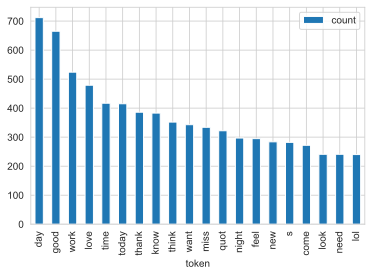

In [41]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

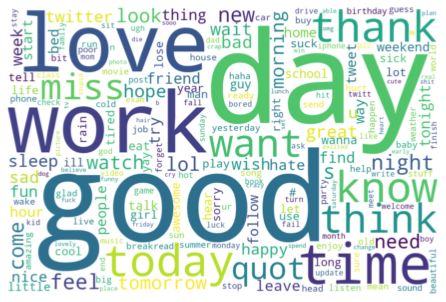

In [44]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

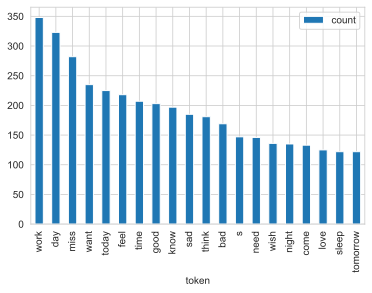

In [45]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

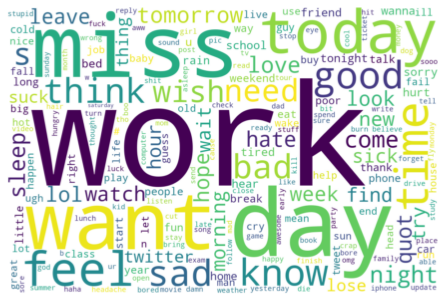

In [46]:
wordcloud(neg_counter)

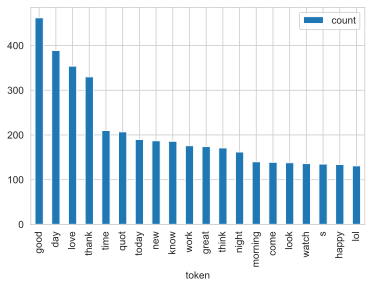

In [47]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

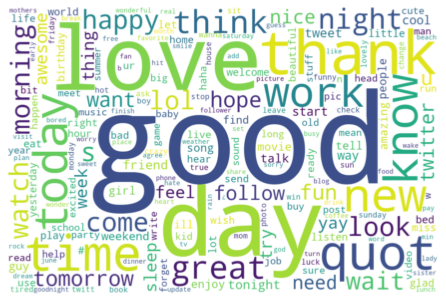

In [48]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [49]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

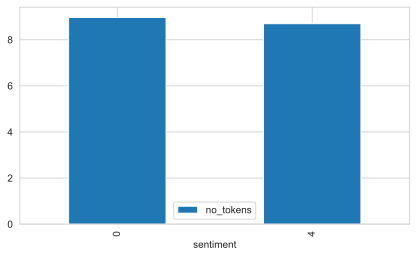

In [50]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [51]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

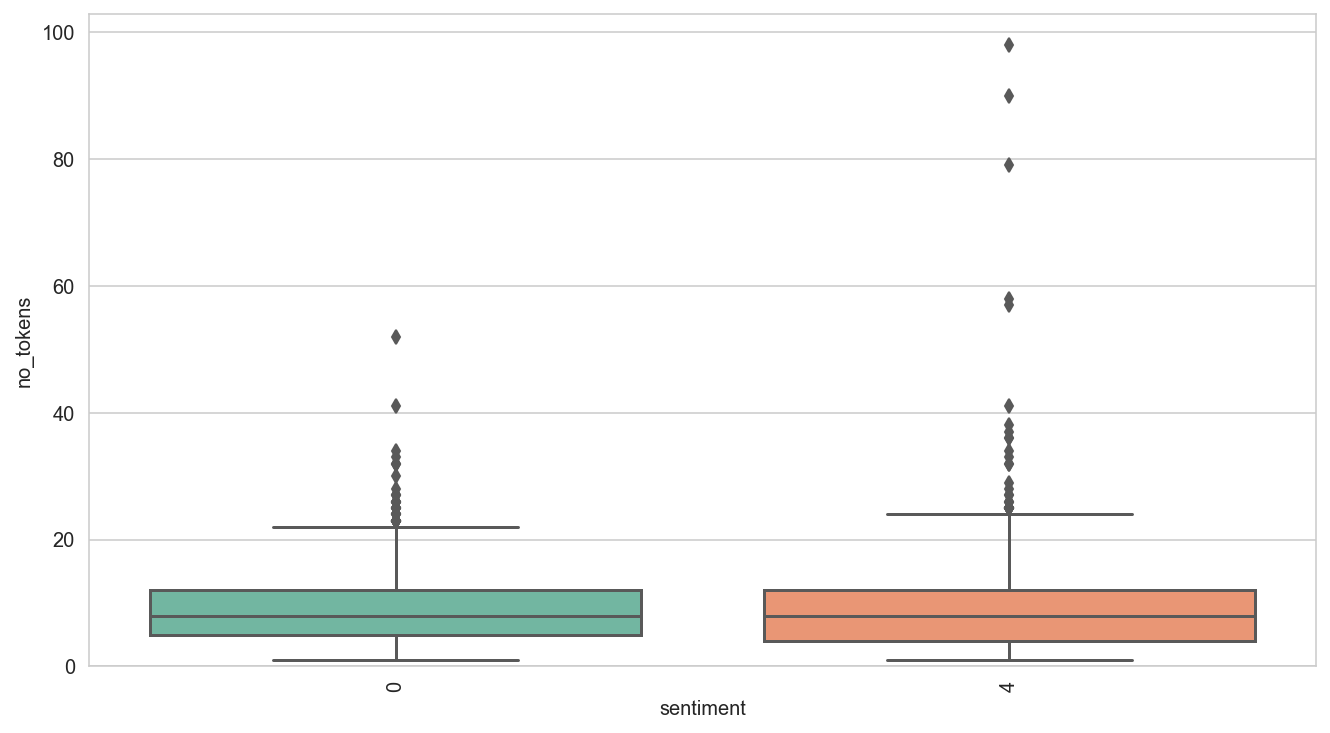

In [52]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [53]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [54]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aa,aaa,aaaa,aaaaaaaahhhhhhh,aaaaahhh,aaaaand,aaaaarg,aaaall,aaaand,aaaaw,aaah,aaahh,aaargh,aaarghhhh,aaarrrrggghh,...,ê³,ï¼,ð²,ð²ðºð,ð²ñ,ðµðµñ,ðµñ,ðºð,ðºðµ,ð½ð,ð½ðºðµ,ð½ð¾ð²,ð¾,ð¾ð,ð¾ñ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [57]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 

In [58]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,alfjur,be,boo,break,come,confident,cyprus,ddami,desire,enforced,finish,freshness,give,go,home,...,saab,sad,sadni,schedule,show,sis,sleepy,study,sunday,throw,tnx,town,wait,wednesday,week
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,1,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [59]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,5))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab_ngrams = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab_ngrams)

,aa hoodie,aa hoodie everyday,aa hoodie everyday mean,aa hoodie everyday mean rude,aaa howard,aaa howard lol,aaa howard lol flat,aaa howard lol flat stern,aaaa miss,aaaa miss car,aaaa miss car mcqueen,aaaa miss car mcqueen rewatched,aaaaaaaahhhhhhh bored,aaaaaaaahhhhhhh bored lol,aaaaaaaahhhhhhh bored lol talk,...,ð¾ð ð² wordpress ð¾ñ,ð¾ð ð² wordpress ð¾ñ ðµñ,ð¾ð ð²ñ,ð¾ð ð²ñ ð²ðºð,ð¾ð ð²ñ ð²ðºð ð¾ð,ð¾ð ð²ñ ð²ðºð ð¾ð ð²,ð¾ð ð½ð,ð¾ð ð½ð ðµñ,ð¾ð ð½ð ðµñ ðºðµ,ð¾ð ð½ð ðµñ ðºðµ ð½ðºðµ,ð¾ð ð¾ð,ð¾ñ ðµñ,ð¾ñ ðµñ ðµñ,ð¾ñ ðµñ ðµñ ð¾ð,ð¾ñ ðµñ ðµñ ð¾ð ð½ð
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [60]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,alfjur pray,boo week,break freshness,come go,confident break,cyprus wednesday,ddami saab,desire player,enforced give,finish study,freshness desire,give lack,go leave,home hour,hour sad,...,pray finish,rb sadni,saab noom,sad come,sadni ddami,schedule go,show go,sis home,sleepy sunday,study wait,sunday lunch,tnx much,town be,wednesday morning,week town
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab_tfidf)

,aa,aaa,aaaa,aaaaaaaahhhhhhh,aaaaahhh,aaaaand,aaaaarg,aaaall,aaaand,aaaaw,aaah,aaahh,aaargh,aaarghhhh,aaarrrrggghh,...,ê³,ï¼,ð²,ð²ðºð,ð²ñ,ðµðµñ,ðµñ,ðºð,ðºðµ,ð½ð,ð½ðºðµ,ð½ð¾ð²,ð¾,ð¾ð,ð¾ñ
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9957,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9958,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9959,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9960,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [62]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,alfjur,be,boo,break,come,confident,cyprus,ddami,desire,enforced,finish,freshness,give,go,home,...,saab,sad,sadni,schedule,show,sis,sleepy,study,sunday,throw,tnx,town,wait,wednesday,week
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.59,0.00,...,0.00,0.00,0.00,0.00,0.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.24,0.00,...,0.00,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.32,0.00,0.00,0.00,0.00,0.32,0.00
2,0.00,0.52,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.00,0.44
3,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.00,0.00,0.00,...,0.32,0.00,0.32,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.32,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.42,...,0.00,0.42,0.00,0.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.35,0.00,0.35,0.00,0.00,0.35,0.35,0.00,0.35,0.35,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 500 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([   21,    37,    64,    70,    94,   117,   143,   171,   201,   256,
         298,   345,   438,   473,   508,   513,   534,   537,   560,   588,
         639,   663,   671,   677,   721,   732,   735,   753,   775,   852,
         855,   862,   876,   891,   910,   927,   936,   968,   992,  1008,
        1021,  1029,  1054,  1060,  1068,  1080,  1131,  1136,  1156,  1166,
        1180,  1183,  1189,  1210,  1237,  1251,  1281,  1287,  1309,  1323,
        1373,  1384,  1385,  1396,  1455,  1485,  1493,  1525,  1529,  1599,
        1608,  1614,  1672,  1720,  1747,  1802,  1836,  1846,  1859,  1861,
        1886,  1894,  1913,  1945,  1958,  1969,  1977,  2013,  2028,  2032,
        2052,  2060,  2063,  2065,  2090,  2095,  2121,  2150,  2163,  2165,
        2173,  2187,  2209,  2212,  2213,  2218,  2220,  2278,  2330,  2331,
        2358,  2382,  2384,  2413,  2414,  2434,  2455,  2503,  2509,  2526,
        2536,  2549,  2567,  2577,  2624,  2665,  2678,  2684,  2721,  2747,

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [64]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

aaron able account ache add adorable afford agree air allergy amazing andyhurleyday appreciate argh art artist ask asleep aswell attend avatar awesome awful aww back bacon bad bake bang bday be bear beautiful bed beg believe belong bestie bgt bill biology birthday blackberry blah blast bless bob body boo booo bore boring boston bowling brand break bright brilliant broke brown build bummed bummer burn calf can cancel captain car cd celebrate cell charge chelsea chill church claim class cleaner cleaning close cloudy cnt cold college com comedy compare compliment computer conference confuse congrat congratulation content continue cool cos cough could couple cover crap crappy crash craving crazy cry cut cute dad dammit damn darling darn day dead degree delay demon dentist depressed design desperate die direct disappointed discount diva do dread dream drive drunk due easy ebay eff empty end enjoy entire ep exam excite excited exhaust exhausted exist express eye fab fail fall fam family fan 

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=6)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [66]:
from sklearn.ensemble import ExtraTreesClassifier

In [67]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[1.72e-05 0.00e+00 2.78e-05 ... 4.78e-06 2.42e-05 0.00e+00]


In [68]:
i=0
n=0
min_imp = 0.00041
min_starred = 0.004
for x in model_bagged.feature_importances_:
    if x>min_imp:
        if x>min_starred:
            print('***', end='')
        print(vocab_bagowords[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

able ache add afraid afternoon agree amazing answer appreciate ask assignment awake awesome awful aww baby back ***bad band ***be beach bear beautiful bed believe big bike bill birthday bit bite blue boo bore bored boring boy boyfriend break bright bring bro broke bummed bummer burn busy butt buy call can cancel car care cat catch cause chance change character chat check chill church class clean cleaning close cloudy coffee cold college come communication confuse congrat congratulation cook cool cough could country course crack crap crash crazy cry cute dad damn dance ***day dead die dinner direct disappointed do doctor dream dress drink drive drop dude due early eat email end enjoy enough exam excite excited exist eye face facebook fail fair fall family fan fantastic fault favorite fb ***feel feelin fever figure find finish finished first fix flat follow followfriday foot forget free friday friend fuck full fun funny future game garden ***get girl give glad ***go god ***good goodbye g

## Note that the stars ( *** ) denote features that were given much higher importances.

## Feature Selection on TF-IDF encoded features

### Filter Method - SelectKBest

In [69]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([   37,    64,    70,    94,   117,   127,   143,   201,   256,   298,
         380,   438,   473,   513,   537,   560,   573,   639,   651,   663,
         671,   677,   735,   753,   775,   852,   855,   862,   876,   910,
         927,   931,   936,   968,   992,  1008,  1021,  1029,  1054,  1060,
        1068,  1080,  1131,  1136,  1150,  1156,  1166,  1180,  1181,  1183,
        1189,  1210,  1237,  1251,  1281,  1287,  1309,  1323,  1373,  1384,
        1385,  1396,  1455,  1485,  1493,  1499,  1525,  1529,  1599,  1672,
        1679,  1720,  1747,  1802,  1836,  1846,  1859,  1861,  1894,  1913,
        1945,  1958,  1977,  2013,  2028,  2032,  2052,  2060,  2062,  2063,
        2065,  2095,  2118,  2121,  2139,  2163,  2165,  2173,  2187,  2209,
        2212,  2213,  2218,  2220,  2268,  2278,  2330,  2331,  2358,  2382,
        2384,  2413,  2414,  2455,  2509,  2536,  2549,  2553,  2577,  2624,
        2665,  2678,  2721,  2747,  2751,  2789,  2848,  2864,  2872,  2905,

In [70]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

able account ache add adorable advert afford air allergy amazing annoyed appreciate argh artist asleep aswell atl avatar awake awesome awful aww bad bake bang bday be bear beautiful beg believe bella belong bestie bgt bill biology birthday blackberry blah blast bless bob body bonfire boo booo bore bored boring boston bowling brand break bright brilliant broke brown build bummed bummer burn calf can cancel candle captain car cd charge charlie chelsea chill church claim class cleaner cleaning cloudy cnt cold college comedy compare compliment computer conference confuse confusing congrat congratulation continue cooking cool cornwall cough could couple cover crap crappy crash craving crazy cruise cry cut cute dad dammit damn darling darn dead delay dentist depressed depression desperate die direct disappointed diva do doctor dooo dread drive drop due easy end enjoy entire ep exam excite excited exhaust exhausted exist express eye fab fail fair fall fam fan fathers fatty fault favorite favo

## RFE on TF-IDF vectors 

In [71]:
#model_tfidf = LogisticRegression(solver='lbfgs', max_iter=6)
#rfe = RFE(model_tfidf, 500)
#fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
#print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)

i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [72]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[3.08e-07 0.00e+00 0.00e+00 ... 8.54e-06 1.60e-05 0.00e+00]


### Making our new array containing only selected features.

### And saving back a copy of the unselected array for future comparisons.

In [73]:
# Save a copy of the unselected features for benchmarking later.
tv_matrix_unselected = tv_matrix
tv_matrix_selected = np.array([])
i=0
n=0
min_imp = 0.00004
min_starred = 0.003
#vector_temp = np.array([np.size(tv_matrix, 0)])
#vector_temp.shape = (np.size(tv_matrix, 0),1)
# a = numpy.zeros(shape=(5,2))
vector_temp = np.zeros(shape = ((np.size(tv_matrix, 0)), 1))
np.shape(vector_temp)


(9962, 1)

In [74]:
tv_temp=tv_matrix[:,i]
tv_temp.shape

(9962,)

In [75]:
tv_temp.shape

(9962,)

In [76]:
np.shape(tv_matrix[:,i])

(9962,)

In [77]:
numrows = (np.size(tv_matrix, 0))

In [78]:
for x in model_bagged_tfidf.feature_importances_:
    
    if x>min_imp:
        tv_temp=tv_matrix[:,i]
        tv_temp.shape = (numrows, 1)
        vector_temp=np.append(vector_temp, tv_temp, axis = 1)
        if x>min_starred:
            
            print('***', end='')
        print(vocab_tfidf[i], end=' ')
        n=n+1
    i=i+1
    #vector_temp = np.array([])
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

aaaaaaaahhhhhhh aaaall aaahh abandon abbie abel abit able abs absolute abt ac accept access accident account accountant accounting acct ace ache act active actress actual ad add addict addiction address adorable adorableist adult adventure adventuredome advert advice advil advocate afford afi afraid afternoon age aggravate aggressive agonize agree ahh ahhh ahhhh ahhhhhh ahmadinejad ahmaze ai aiden aim air aircon airport aja akon al alarm album alcohol aldo ale alert alex allergic allergy alligator allison allow allowance almonds alot alreadyi alright alrightttt alse altho alyssalaganosky ama amazing amazinggg amelia america american amount ampe amy ana analyse andi andre andy andyhurleyday angel angwy animal anna annnnd announce annoyed annoying annual answer antm antthe anyone anything apb apetit api app appeal appear applaud apple apply appointment apppoint appreciate apt ar arabcrunch archie areee argh arm armo army arrive arrived arrrgh arse art artist asa asap asgmnt ashley ask as

german germans germany ***get getaway gettin gf ghost giant gift gig giggle gimme ginger gio girl girlie girrrrl give glad glass glee gloomy glue gma gnight ***go goal god goddddd goign going goingg golf gomez gona gone ***good goodbye goodluck goodmorne goodnight goodnite goodrem google googleing goood gorgeous gosh gots gprof gprs gr grab grad graduate graduation grainne gran grand grandma grapevine grass greaaaat grease ***great green greenfield greet greeting grill grimm grind grissom grocery gross ground group groupie grow grr grrr grrrr grrrrrrrr gruesome grumpy gs gta guard gucci gue guess guitar gummy gunna gurl gutte gutted guy guysss gym haha hahah hahaha hahahaha hahha hailey hair haircut hairspray hairy haiz half hallelujah hammer hand hang hangin hanna hannah happen happend happiness ***happy hard harhar harpenden harry harsh hat ***hate hater hates hatton hautjobb hav have havnt hay hayfever hayley hbo hd head headache headake headin headset heaintwentnowheresince heal he

rd re reach read readd reader reading ready real realise realize reallllyyyy reason reblogging rebuild receive recipe recital reckon recognize recommend recommendation red redang redbull redesign redness redo reds reeeal reese refer refreshed refuse regard regexs regina regret regular rehearsal reinstall reject relationship relax relaxation release rematch remembaaa remember remind reminder remodel remote render rent repetitive replacement replay replied reply replys report reschedule research reset reside resist resort respond response rest restaurant restore result ret retrospect return retweet retweete retweeted reunion reusable review revise revising revision reward reznor rhodes rice ride ridiculous riding right riku ring rip rise rite road rob robot rock rockshow rofl role roll rollercoaster romans romantic rome room rope rosebud rough round row roy royal rub rubbish rude rugby ruin rule rumble rumor run runny rush rusk ruv ryan sa sac sack ***sad sadd sadden sadness sadnow safar

In [79]:
np.shape(tv_matrix)

(9962, 11572)

In [80]:
np.size(tv_matrix, 0)

9962

In [81]:
np.shape(vector_temp)

(9962, 3500)

In [82]:
print(vector_temp[0,:])
vector_temp = vector_temp[:,1:]

[0. 0. 0. ... 0. 0. 0.]


In [83]:
#tv_matrix = vector_temp
vector_temp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [84]:
tv_matrix = vector_temp
tv_matrix.shape

(9962, 3499)

# A record and summary of 6 types of Feature Selection

## Because I WILL be dropping RFE for being too intensive.

### Running with 3000 samples gave us vectors with around 5000 dimensions. After much running time, we were able to visually inspect the 500 most important features, as selected by each method. It is perhaps not informative to look at, and compare, these lists of features - but it is fun. And it may give some "subconscious" intuition into that age-old question, "What are these things thinking?" So, before I disable some of these, so I can run bigger datasets through all this code, here's a record of this activity, in the comments/markdown.

I will, quite simple, strip the top two and bottom two rows of each output, and paste them here with clear labels. Pretty sure I won't be running RFE going forward - spins forever, with a pretty low number of samples.

#### SelectKBest with Bag of Words
account actress add age agree ahhh airport amazing american angel animal anne anniversary announce answer appreciate arm arrive attend awesome awful aww awww back bad battle beach beautiful bed bedtime beer believe beloved beyonce birthday blog blonde blue boo book boy boyfriend brand brave britney bro ... tomorrow tongue toooo tragic trust tt tuesday tweet twilight twin twit twitter ugh ughhh unc unfair update updates upgrade upload upset ur use vacuum vegas version voice vote wait walters want warped wat watch way wayne website welcome window wish woke woman wonderful woop work wrist wrong wtf xd xoxo yay young youth yup
#### RFE with Bag of Words
aargh account add addict address afraid age agree ahhh air airport album amazing angel anniversary answer app arm arrive artistic attack attend attention awesome awful awsome aww baby back bad bag battle bc beach bed bet big birthday bit blib blog blue bonjour boo bore bored boy boyfriend brain brand break ... tragic true trust tuesday tv tweeting twin twit twitter ugh unc understand unfair updates upgrade upload upset vacation vegas version vibe video vote wait walmart wanna want wat watch way wayne welcome whole whyyyy wife win wish woke wonder wonderful woop word work working world write wrong wtf xavier xd yay young yup
#### Extra Trees Forest with Bag of Words
able account add addict afraid age agree ahhhh air album alex amazing angel apettite arm art audrey awesome awful aww baby back bad bag battle bc be beach beautiful bed begin beloved big bit blaaaaarg blache blog boo bore boy boyfriend break bubba bug burn bus bye call can cancel cancer car care cat cause ... twitter ugh ughh uncle unfair unusual upgrade upgradeable upload upset upsetting ur use vacation vibe vote wait wake walk wanna want warm warning watch way weather wee week weekend welcome well wholee will wish wishing woke woman wonderful work working world would wrong xoxo yay yeanot year yesterday young yup zoo
#### SelectKBest with TF-IDF
account actress add adore age agree ahaha ahhh airport amazing american anal angel anne anniversary announce annoying answer apologize appreciate arm arrive attend awesome awful awsome aww back background bad bag battle beach beautiful beauty bed bedtime beer beie believe beloved bestie beyonce birthday ... touchy tragic trust tuesday tweetie twilight twin twit twitt twitter ugh ughhh unc uncle understand unfair updates upload upset upsetting use va vegas version view voice vote wait wallpaper want watch way website welcome westney window wish woke woman wonderful woo work wrong xd xoxo yay yayyy young youth yup zoo 
#### RFE with TF-IDF
able account add address afraid age agree ahhh airport album amazing american angel anne anniversary answer appreciate arm arrive art attention awesome awful awsome aww back background bad bag battle bc be beach bed believe big birthday bit blog blue bonjour boo book bore bout boy boyfriend brand brb break bro ... upsetting va vacation vegas version vibe vote wait walk wanna want watch way wee welcome whole window wish wishing woke wonder wonderful word work working world wrong wtf xoxo yay young yud yup zoo
#### Extra Trees Forest with TF-IDF
able actress add addict afraid age agree ahhhh airport alex amazing andrewcilley angel apettite arm art awesome awful aww baby back bad battle bc be beach beautiful bed believe beloved big bit blaaaaarg blache blackberrys blog boo book bore bowls boy boyfriend break brussels bubba bug bunny burn butterfly ... upgrade upgradeable upload upset upsetting ur use vacation vegas vibe video wait wake walk walmart wanna want warm warning watch way weather wee week weekend welcome well whole wholee will window wish wishing woke woman wonderful word work working world worried would wrong xoxo yay yeanot year yesterday young yud yup yuri zoo  



## Last but (maybe) not least - Selecting with our Bag-of-N-Grams

#### Comparing features for Bag-o-words and TF-IDF was very much like comparing apples with apples.

This is going to look a little different, I'll bet, so I'll keep it out from between those two.

In [85]:
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
#selector_ngrams = SelectKBest(chi2, k=400)
#selected_features_ngrams = \
#ngrams_selected = selector_ngrams.fit(bv_matrix, df_sm['sentiment']).get_support(indices=True)
##selected_features_ngrams

KeyboardInterrupt: 

In [ ]:
#for x in selected_features_ngrams:
#    print(vocab_ngrams[x], end=' -       - ')

# RFE with Bag of N-Grams?

## Sorry, no.

## RFE takes a fabulously long time, even with a few thousand vectors with a few thousand dimensions.

My bag-o-n-grams has 2-grams, 3-grams, and 4-grams. It's kinda fun. With 3000 samples, it has TENS of THOUSANDS of dimensions. I think RFE, in general, won't play a big role in my plans. I suppose I could run this on a few hundred samples to see if it works. But so what if it does? Can't move ahead with any constructive with dinky little dataframes like that. 

# Let's do the forest with the ngrams and call it a day.

model_bagged_ngrams = ExtraTreesClassifier(n_estimators=20)
model_bagged_ngrams.fit(bv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_ngrams.feature_importances_)
# np.set_printoptions(threshold=200)

i=0
n=0
min_imp = 0.00041
min_hilite = 0.0028
for x in model_bagged_ngrams.feature_importances_:
    if x>min_imp:
        if x>min_hilite:
            print('|||--', end="")
            print(vocab_ngrams[i], end='--||| -       - ')
        else:
            print(vocab_ngrams[i], end=' -       - ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

# Milestone 1 - Conclusion



#  ------> CUT

Code, output, and markdown for everything up to Milestone 1 has been removed for ease of Milestone 2

# Beginning of Milestone 2

Working models.

We will train and evaluate a Merry Assortment of Machine Learning Algorithms, and then put them all through a battery of Evaluations to compare and contrast the resulting models.

###### Model Selection

### In this section we will train and test models using 6 different algorithms, and then compare their accuracy.

This can help us understand which type of models works best with our data, and allow us to identify problems using certain types of models with our data.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_sm['text_nav'], df_sm['sentiment'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#clf = MultinomialNB().fit(X_train_tfidf, y_train)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [88]:
print(clf.predict(count_vect.transform(["I absolutely love this code."])))

[4]


In [89]:
print(clf.predict(count_vect.transform(["Not sure what I think of this one."])))

[4]


In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score


models = [
    DecisionTreeClassifier(criterion='entropy', max_depth=2),
    KNeighborsClassifier(n_neighbors=1),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, tv_matrix, df_sm['sentiment'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

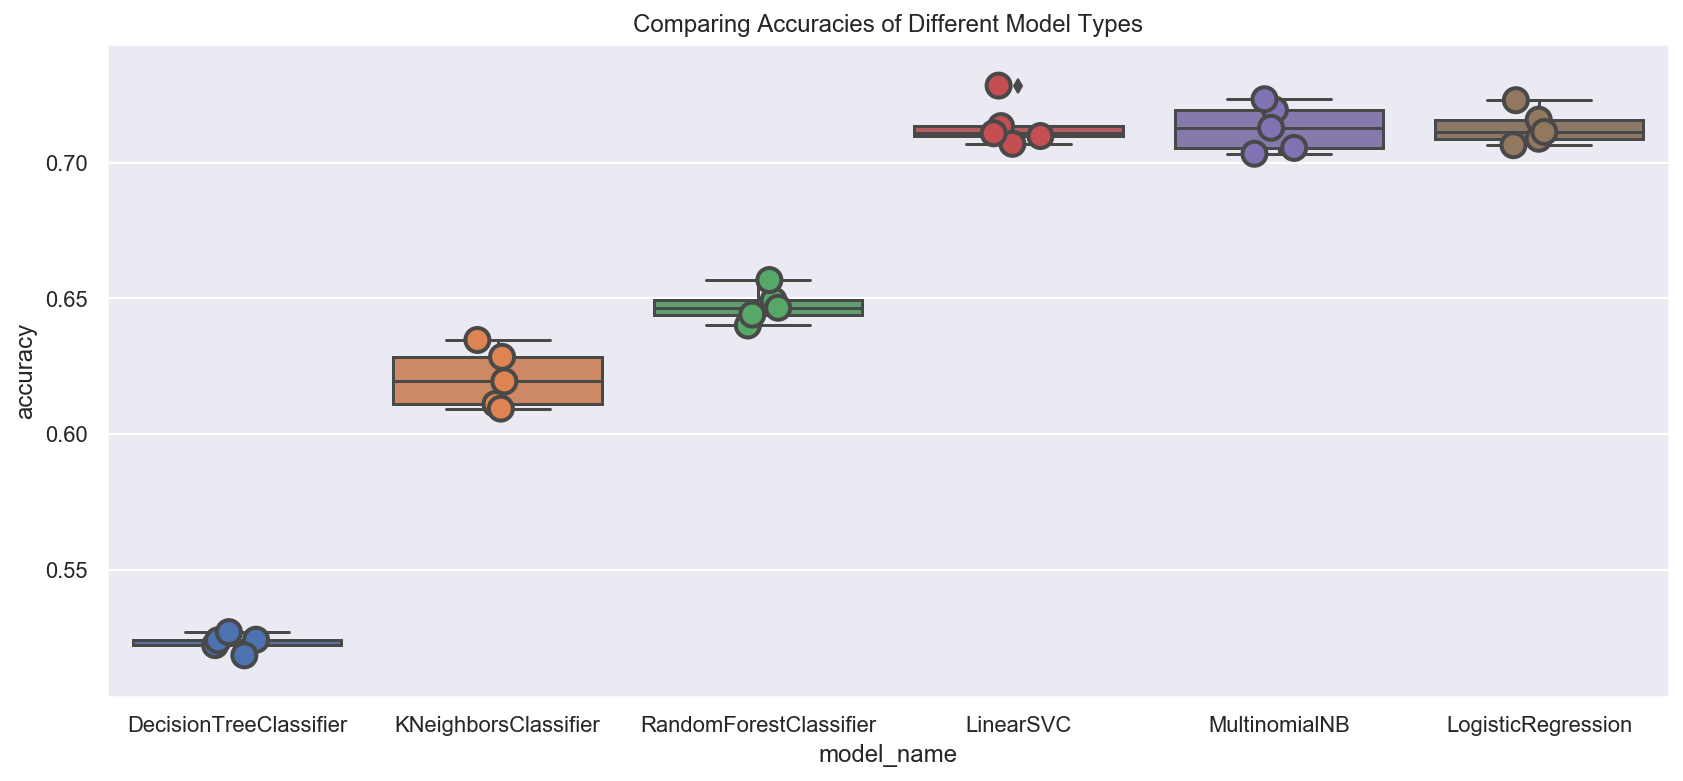

<Figure size 1152x432 with 0 Axes>

In [92]:
import seaborn as sns

sns.set(rc={'figure.figsize':(14,6)})

sns.boxplot(x='model_name', y='accuracy', data=cv_df, width=0.8).set_title('Comparing Accuracies of Different Model Types')
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.figure(figsize=(16, 6))
#plt.set_size_inches(18.5, 10.5)
plt.savefig('test2png.png', dpi=100)
plt.show()


In [93]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier   0.52
KNeighborsClassifier     0.62
LinearSVC                0.71
LogisticRegression       0.71
MultinomialNB            0.71
RandomForestClassifier   0.65
Name: accuracy, dtype: float64

## Observation:

My first attempts at Ensembling yielded pretty dubious results. More dubious than some of these standalone models. Looking at this graphs helps explain why - the code I was originally using for Ensemble Methods used Decision Tree and K-Nearest-Neighbour. This graph suggests that these models perform poorly compared to SVC, NB, etc. Which gives us something to go on, in our quest to make the Ensemble Methods produce better results - Ensemble more powerful models!

# ====================================

# LinearSVC (<i>Support Vector Classifier</i>) Model

Split into training and test sets, train model on training set, generate predictions on test set.

In [94]:
from sklearn.model_selection import train_test_split

model_svc = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(tv_matrix, df_sm['sentiment'], df_sm.index, test_size=0.33, random_state=0)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

# Confusion Matrix: LinearSVC

Calculate, and display, true positives, true negatives, false positives, and false negatives.

We'll show both the raw matrix, and a "Heatmap", which looks cool, but doesn't give too much insight with only two labels.

RAW CONFUSION MATRIX 

[[1095  535]
 [ 413 1245]] 

Because the heatmap may LOOK cool, but doesn't tell us much, with only two labels 

--------------------

Heatmap of Consfusion Matrix:


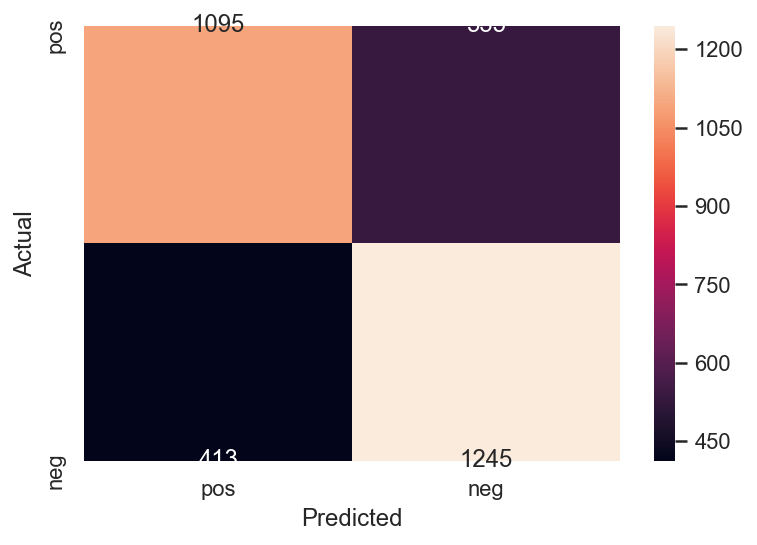

In [95]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('Because the heatmap may LOOK cool, but doesn\'t tell us much, with only two labels \n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [96]:
model_svc.fit(tv_matrix, df_sm['sentiment'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Precision, Recall and f1-Score: LinearSVC

In [97]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1630
           4       0.70      0.75      0.72      1658

    accuracy                           0.71      3288
   macro avg       0.71      0.71      0.71      3288
weighted avg       0.71      0.71      0.71      3288



# ROC Curve: LinearSVC

Using code and wisdom from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

A useful tool when predicting the probability of a binary outcome is the <b>Receiver Operating Characteristic curve</b>, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.768

ROC Curve for LinearSVC Classifier:


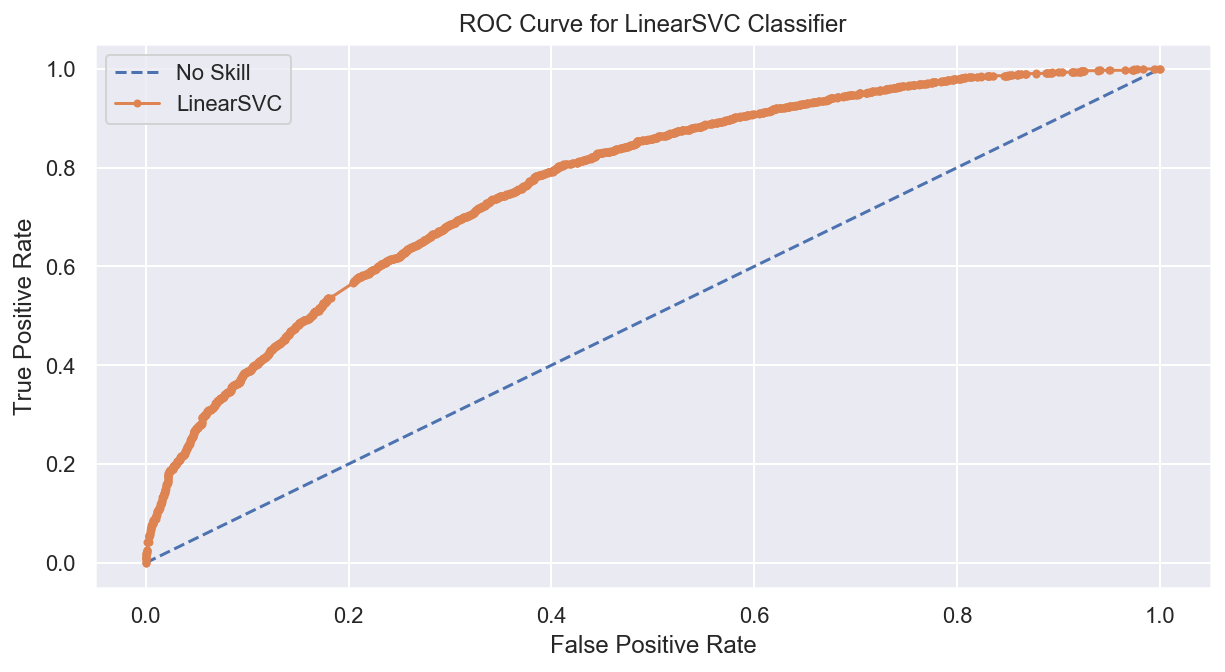

In [98]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Shrink back our Seaborn graph size - don't need it as big as we had for the accuracy comparison.
sns.set(rc={'figure.figsize':(10,5)})

# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
model_svc.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = model_svc._predict_proba_lr(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for LinearSVC Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LinearSVC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for LinearSVC Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

This ROC curve shows considerably higher "skill" than the "no skill" curve, which represents the perfomance of a classifier that just guesses the most likely thing.

# AUC - Area Under the Curve

The "skill" of this model can be represented by the AUC score - the Area Under the Curve - and we do note that despite the LinearSVC model having the highest accuracy and f1-score of the models we tried, Logistic Regression appears to have a higher AUC, as we will see below.

## Precision-Recall Curve: LinearSVC Model

LinearSVC: f1=0.846 auc=0.899


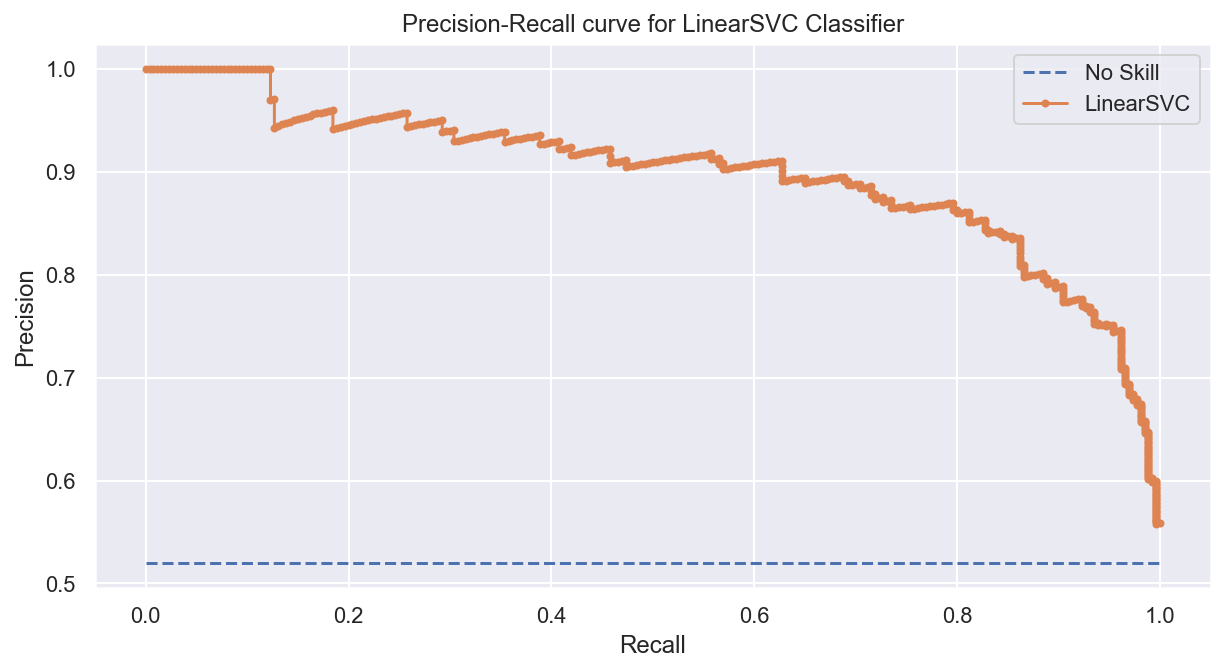

In [99]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
# model = LogisticRegression(solver='lbfgs')

# use our model
model = model_svc

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model._predict_proba_lr(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('LinearSVC: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='LinearSVC')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall curve for LinearSVC Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The precision-recall curve plot show the precision/recall for each threshold for a Linear Support Vector Classifier model (orange) compared to a no skill model (blue).

## When to Use ROC vs. Precision-Recall Curves?

Again from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Generally, the use of ROC curves and precision-recall curves are as follows:

- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.

The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.

## As our dataset is very very balanced, we will lean towards ROC.

## Learning Curves: LinearSVC

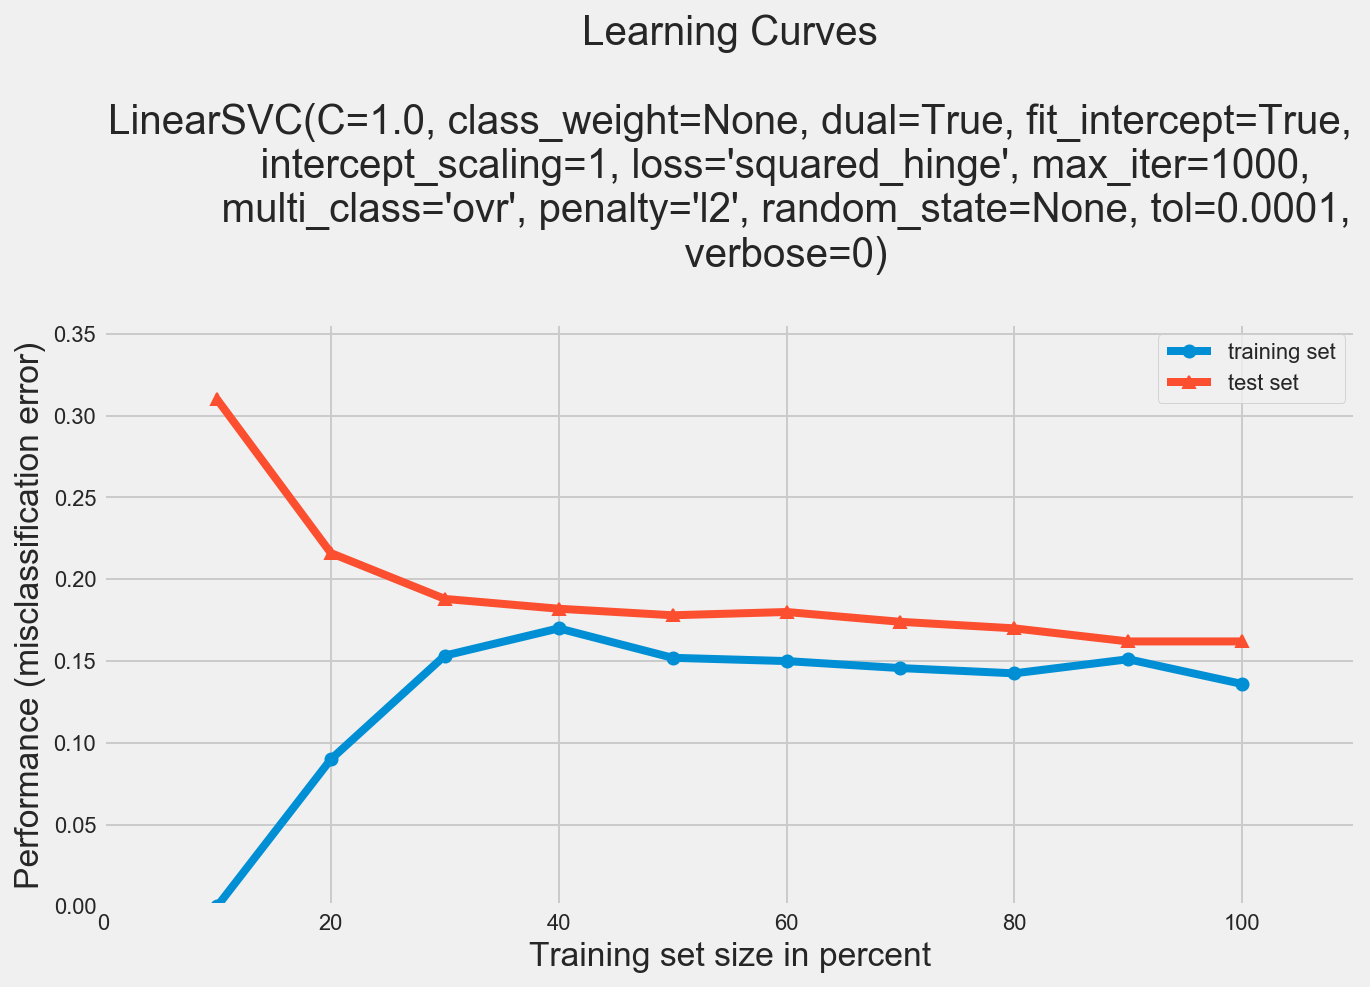

In [100]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_svc)
plt.show()

# ============================

# Logistic Regression

We'll do the same metrics for Logistic Regression as we did for LinearSVC


Confusion Matrix for Logistic Regression Model: 

[[1102  528]
 [ 424 1234]] 

Confusion Matrix for Logistic Regression Model as a little heatmap:


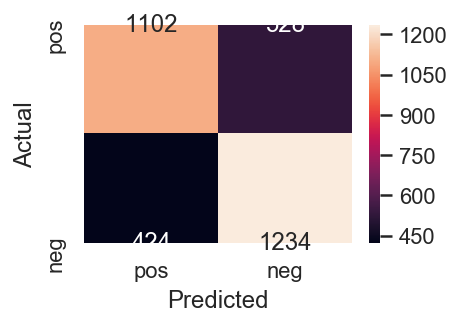


Precision, Recall, F1-scores for Logistic Regression Model: 

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1630
           4       0.70      0.74      0.72      1658

    accuracy                           0.71      3288
   macro avg       0.71      0.71      0.71      3288
weighted avg       0.71      0.71      0.71      3288



In [101]:
model_lr = LogisticRegression(random_state=0)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Logistic Regression Model: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Logistic Regression Model as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Logistic Regression Model:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

## ROC Curve: Logistic Regression Classifier

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.780

ROC curve for Logistic Regression Classifier:


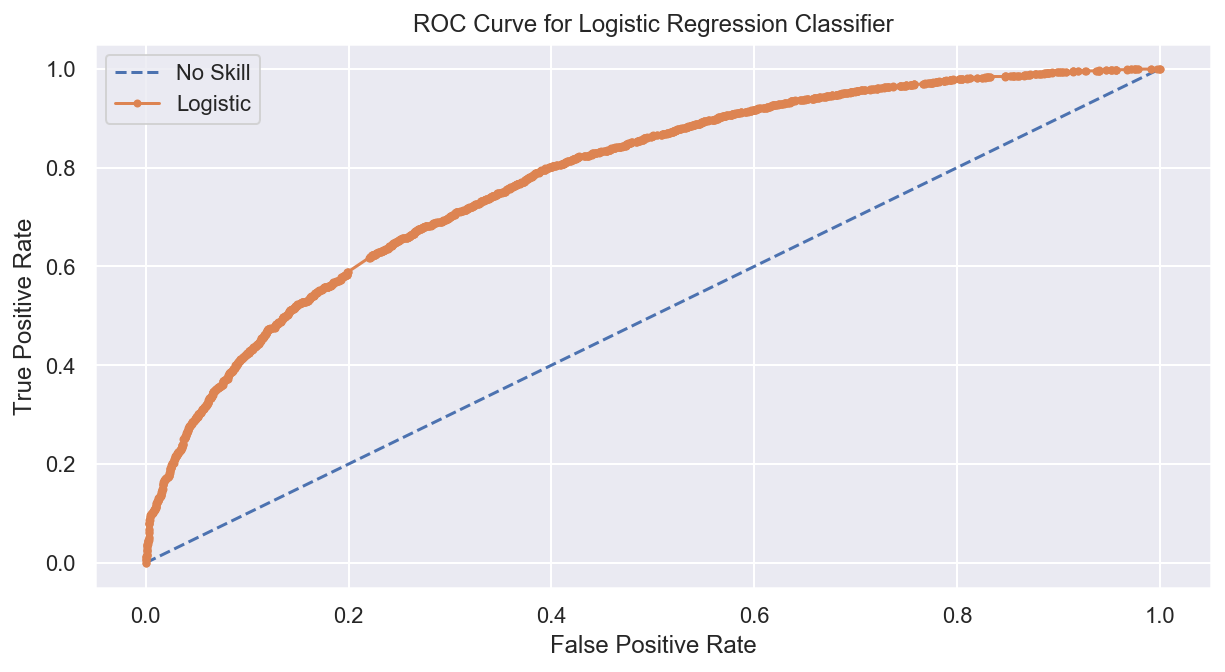

In [102]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_lr

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('\nROC curve for Logistic Regression Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Precision-Recall Curve: Logistic Regression

Logistic Regression: f1=0.841 auc=0.898


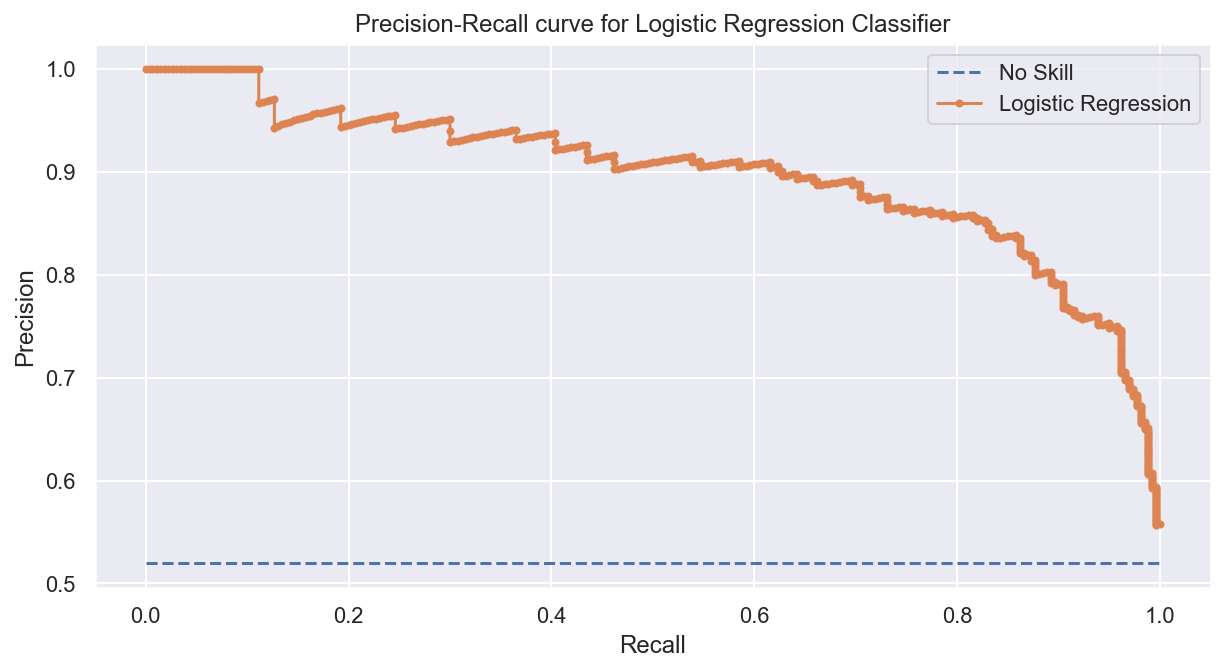

In [103]:
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
# model = LogisticRegression(solver='lbfgs')

# use our model
model = model_lr

model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic Regression: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Precision-Recall curve for Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curves: Logistic Regression

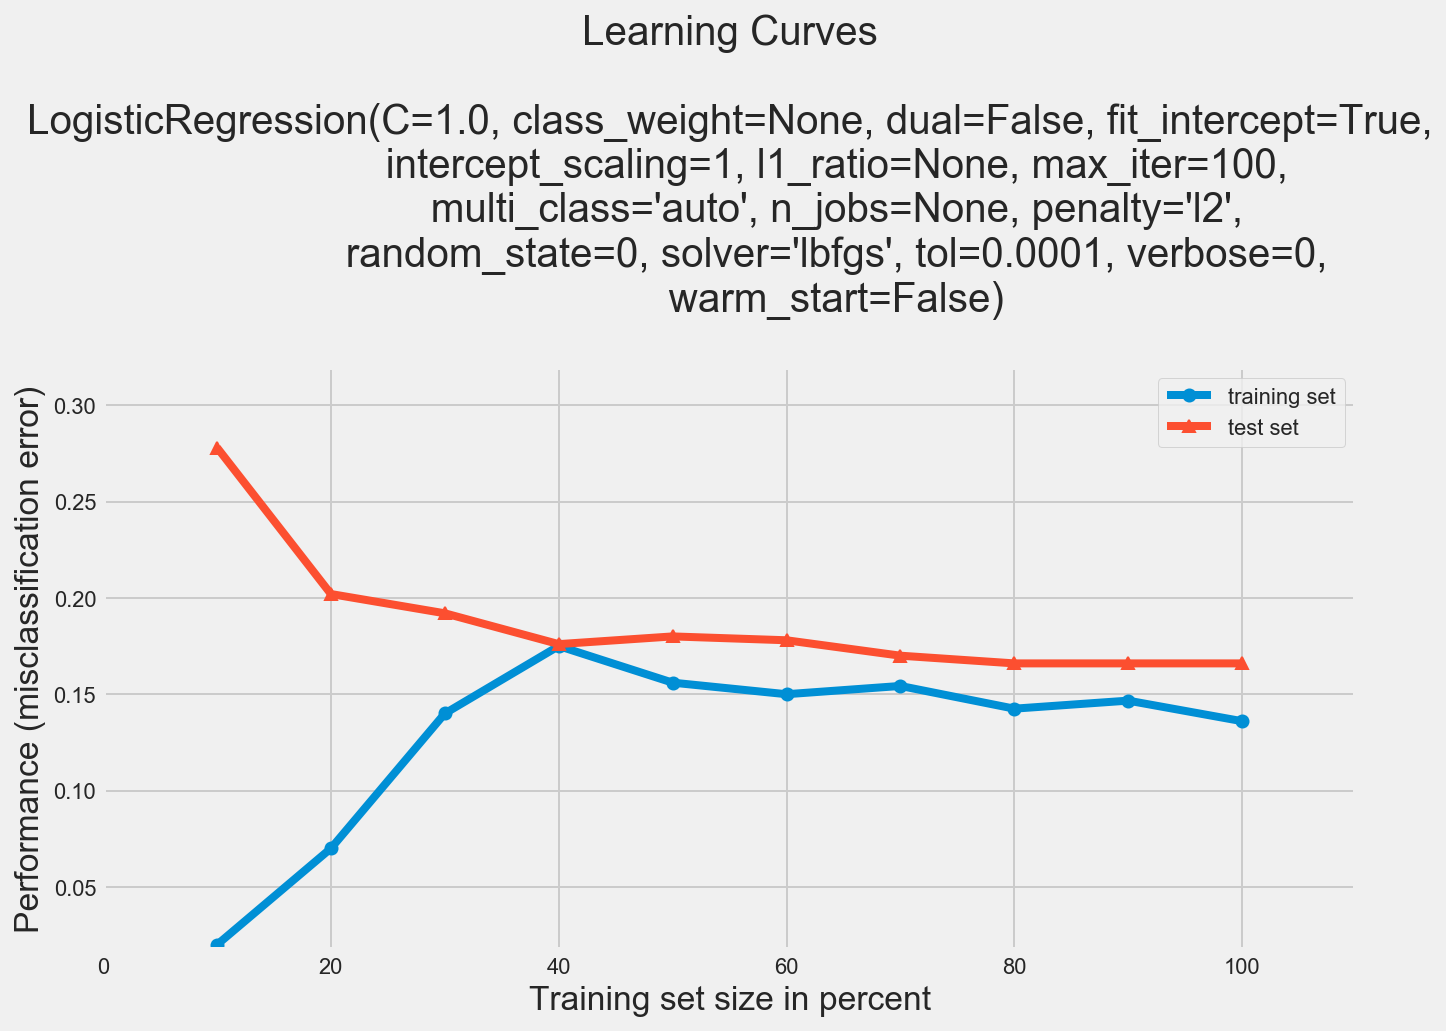

In [104]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_lr)
plt.show()

# ===========================

# Multinomial NB Classifier

The <b>Multinomial Naive Bayes classifier</b> is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.


Confusion Matrix for Multinomial Naive Bayes Classifier: 

[[1109  521]
 [ 408 1250]] 

Confusion Matrix for Multinomial Naive Bayes Classifier as a little heatmap:


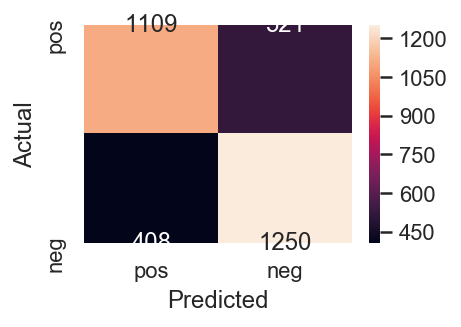


Precision, Recall, F1-scores for Multinomial Naive Bayes Classifier: 

              precision    recall  f1-score   support

           0       0.73      0.68      0.70      1630
           4       0.71      0.75      0.73      1658

    accuracy                           0.72      3288
   macro avg       0.72      0.72      0.72      3288
weighted avg       0.72      0.72      0.72      3288



In [105]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred = model_mnb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Multinomial Naive Bayes Classifier: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Multinomial Naive Bayes Classifier as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Multinomial Naive Bayes Classifier:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

# ROC and AUC: MultinomialNB

As with above.

No Skill: ROC AUC=0.500
MultinomialNB: ROC AUC=0.766

ROC Curve for MultinomialNB:


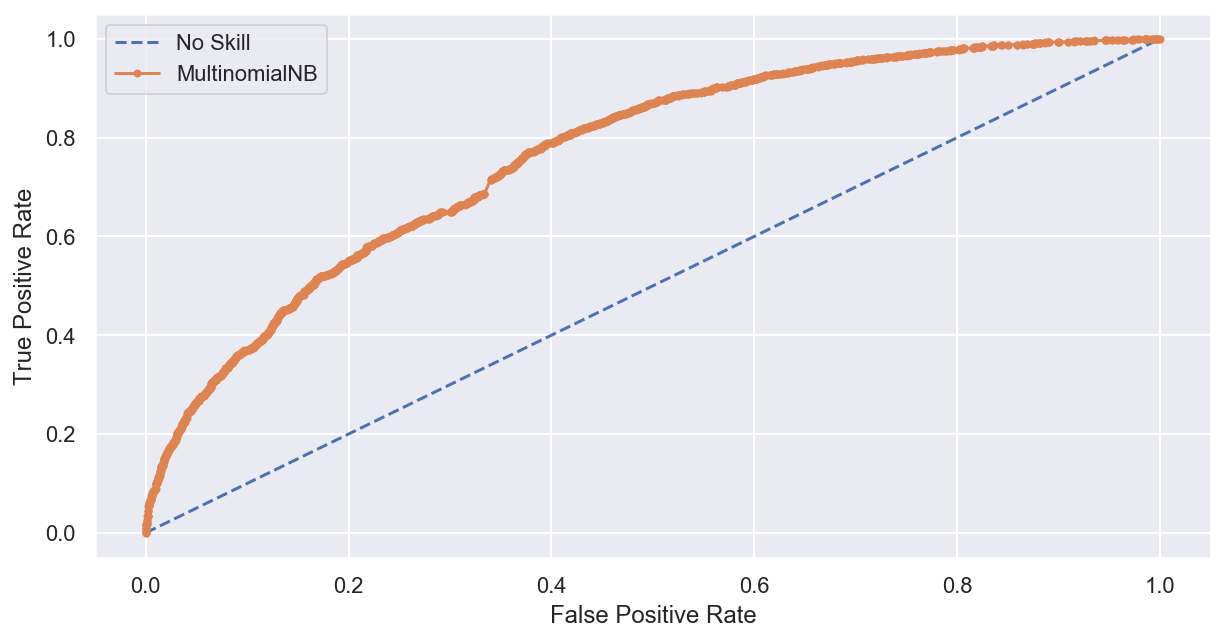

In [106]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_mnb

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('MultinomialNB: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for MultinomialNB:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='MultinomialNB')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curves: MultinomialNB

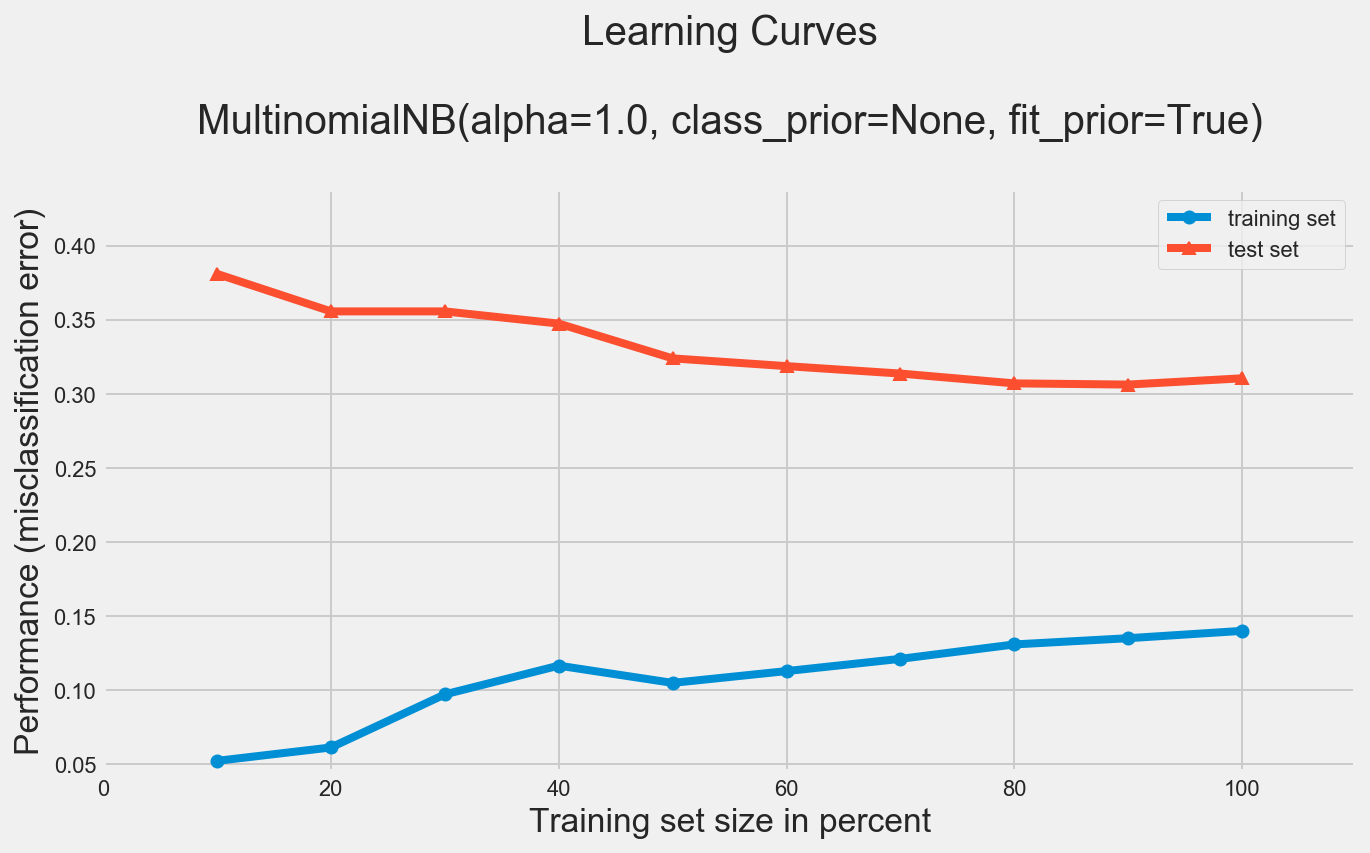

In [107]:

plot_learning_curves(trainX, trainy, testX, testy, model_mnb)
plt.show()

# ===============================================

# Random Forest Classifier

It did perform poorly on the "accuracy" comparison, especially with the really small dataset, but as we've seen above, accuracy is a poor predictor of other performance measures.


Confusion Matrix for Random Forest Classifier: 

[[ 915  715]
 [ 317 1341]] 

Confusion Matrix for Random Forest Classifier as a little heatmap:


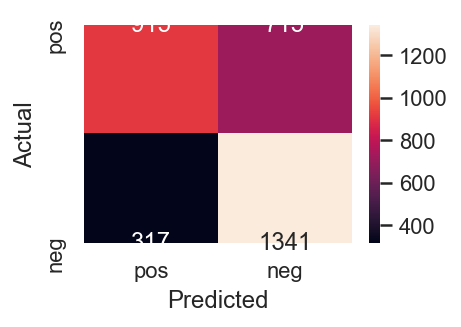


Precision, Recall, F1-scores for Random Forest Classifier Classifier: 

              precision    recall  f1-score   support

           0       0.74      0.56      0.64      1630
           4       0.65      0.81      0.72      1658

    accuracy                           0.69      3288
   macro avg       0.70      0.69      0.68      3288
weighted avg       0.70      0.69      0.68      3288



In [108]:
model_rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
#model_mnb = MultinomialNB()
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix for Random Forest Classifier: \n')
print(conf_mat , '\n')
print('Confusion Matrix for Random Forest Classifier as a little heatmap:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('\nPrecision, Recall, F1-scores for Random Forest Classifier Classifier:', '\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

Okay! That is our worst one so far, both in terms of accuracy AND f1-score. Let's do the ROC curve!

## ROC Curve and AUC metric: Random Forest

No Skill: ROC AUC=0.500
Random Forest Classifier: ROC AUC=0.761

ROC Curve for Random Forest Classifier:


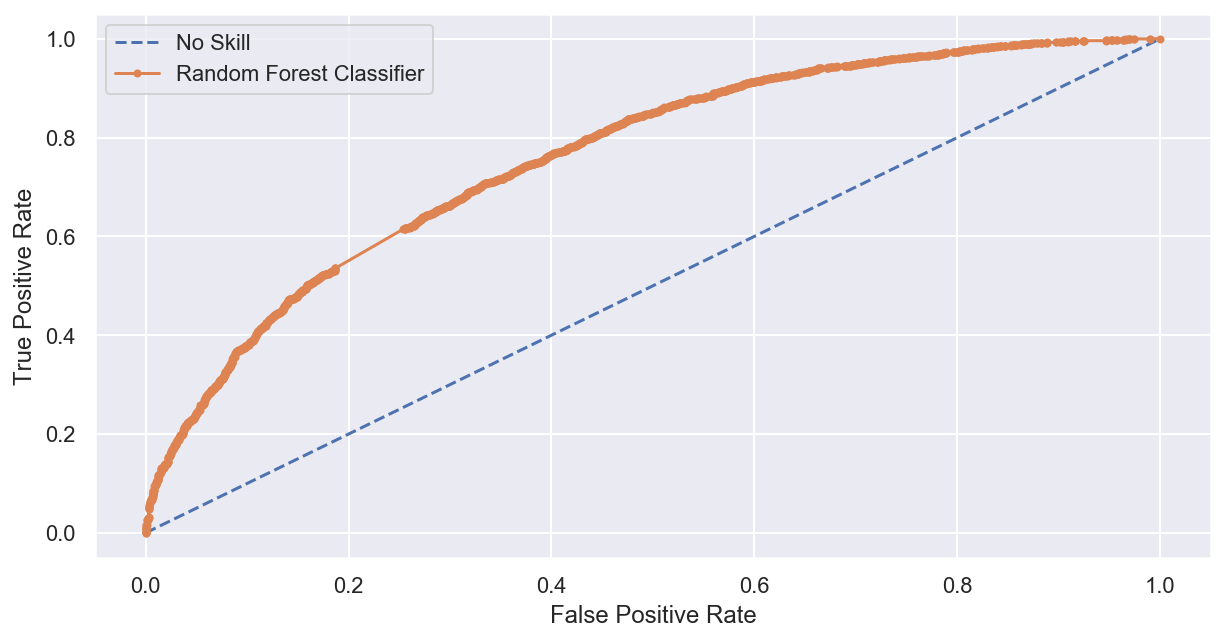

In [109]:
# Use our vectorized and feature-selected data
X = tv_matrix
y = df_sm['sentiment']

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# use our model as defined above
model = model_rfc

#LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest Classifier: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Random Forest Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest Classifier')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Learning Curve: Random Forest

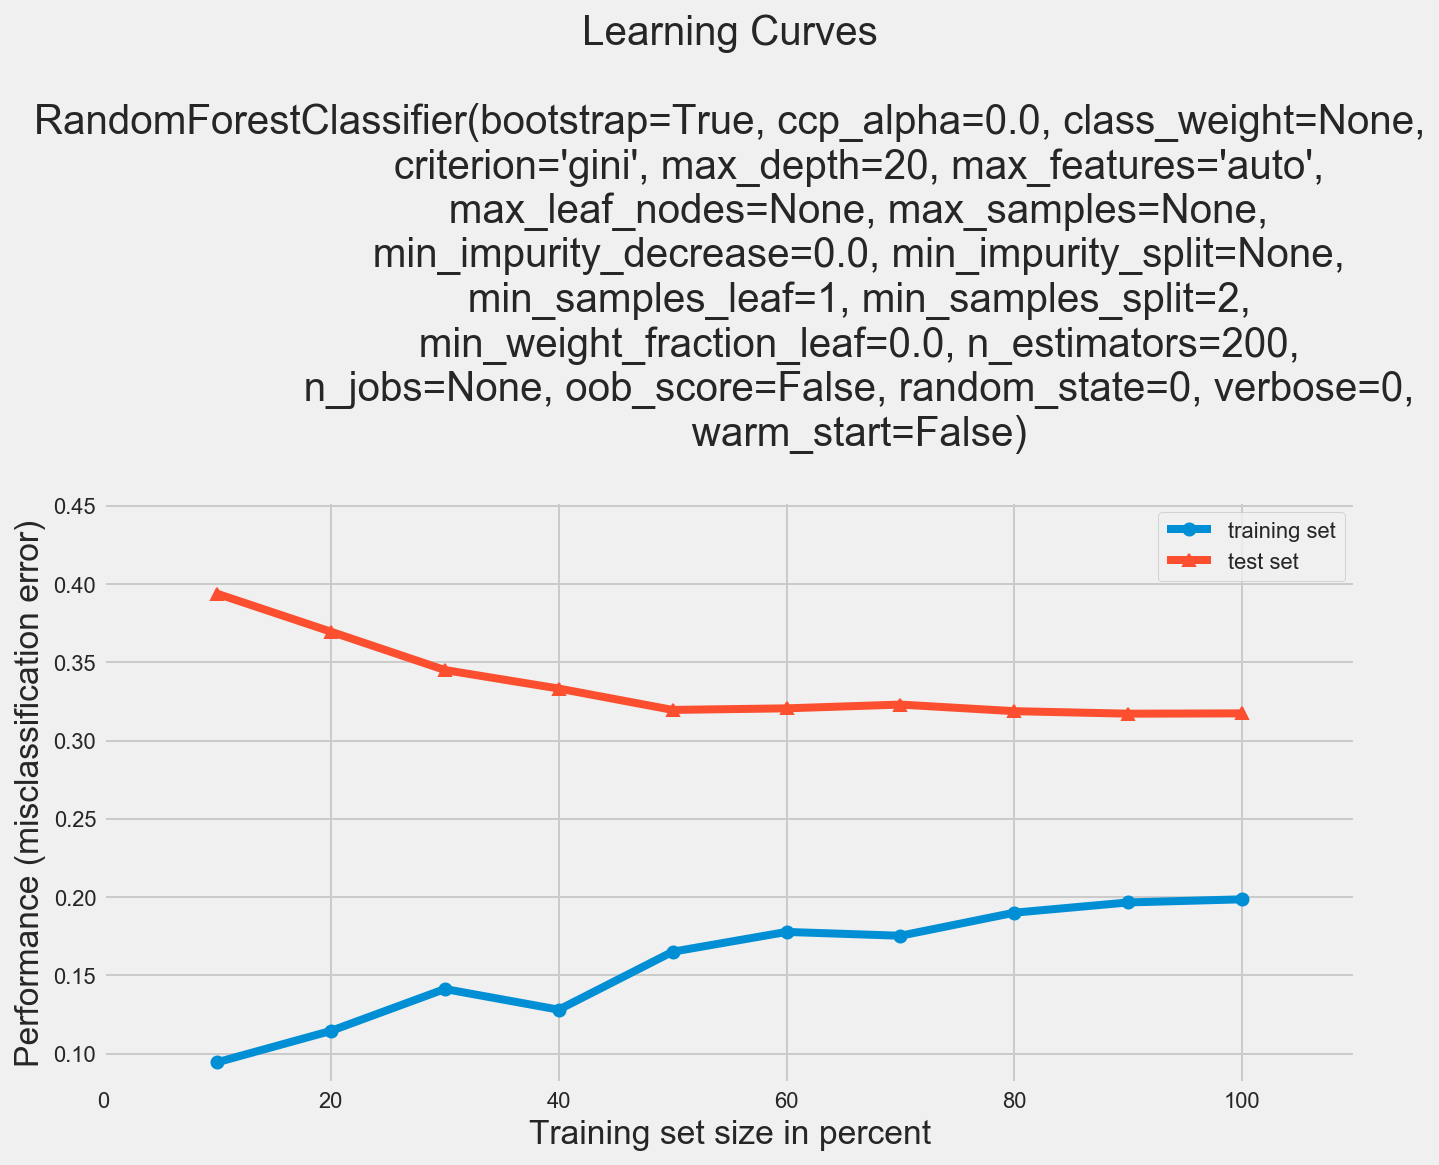

In [110]:
from mlxtend.plotting import plot_learning_curves
#plot_learning_curves(X_train, y_train, X_test, y_test, model_svc)
plot_learning_curves(trainX, trainy, testX, testy, model_rfc)
plt.show()

## Interesting points of comparison!!

Early in this project, I was doing sentiment predictions with Afinn, to be used as a baseline later. At our first arrival at this point, things are looking better already!

#### Weighted Avg F1-Scores
-----------------------------------

0.63 - Afinn original values.

0.70 - Logistic Regression, 800 rows total, Tf-idf encoding

0.74 - LinearSVC, 800 rows total, Tf-idf encoding


# ============================

# Ensembling

# ============================

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: sequential ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and parallel ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight. The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging.

Most ensemble methods use a single base learning algorithm to produce homogeneous base learners, i.e. learners of the same type leading to homogeneous ensembles. There are also some methods that use heterogeneous learners, i.e. learners of different types, leading to heterogeneous ensembles. In order for ensemble methods to be more accurate than any of its individual members the base learners have to be as accurate as possible and as diverse as possible.

# Bagging

Bagging stands for <b>bootstrap aggregation</b>. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:

\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

<b>Translation:</b> <i><u>The final result is the average of the M sub-results.</u></i>

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

In [111]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

## In the coding example used for this section of the project, ensemble methods are used on Decision Tree Classifiers and K Nearest Neighbour Classifiers.

As we saw in our comparison on standalone models, these are the two worst, of the six we tried. We will instead use Logistic Regression and a Linear Support Vector Classifier for our Ensemble Methods.

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [113]:
# X, y = iris.data[:, 0:2], iris.target

X = tv_matrix
y = np.array(df_sm['sentiment'])
    
clf1 = LogisticRegression(random_state=0)
clf2 = LinearSVC()   

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=12, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=12, max_samples=0.8, max_features=0.8)

Accuracy: 0.72 (+/- 0.00) [Logistic Regression]
Accuracy: 0.71 (+/- 0.01) [LinearSVC]
Accuracy: 0.70 (+/- 0.00) [Bagging Regression]
Accuracy: 0.71 (+/- 0.00) [Bagging SVC]


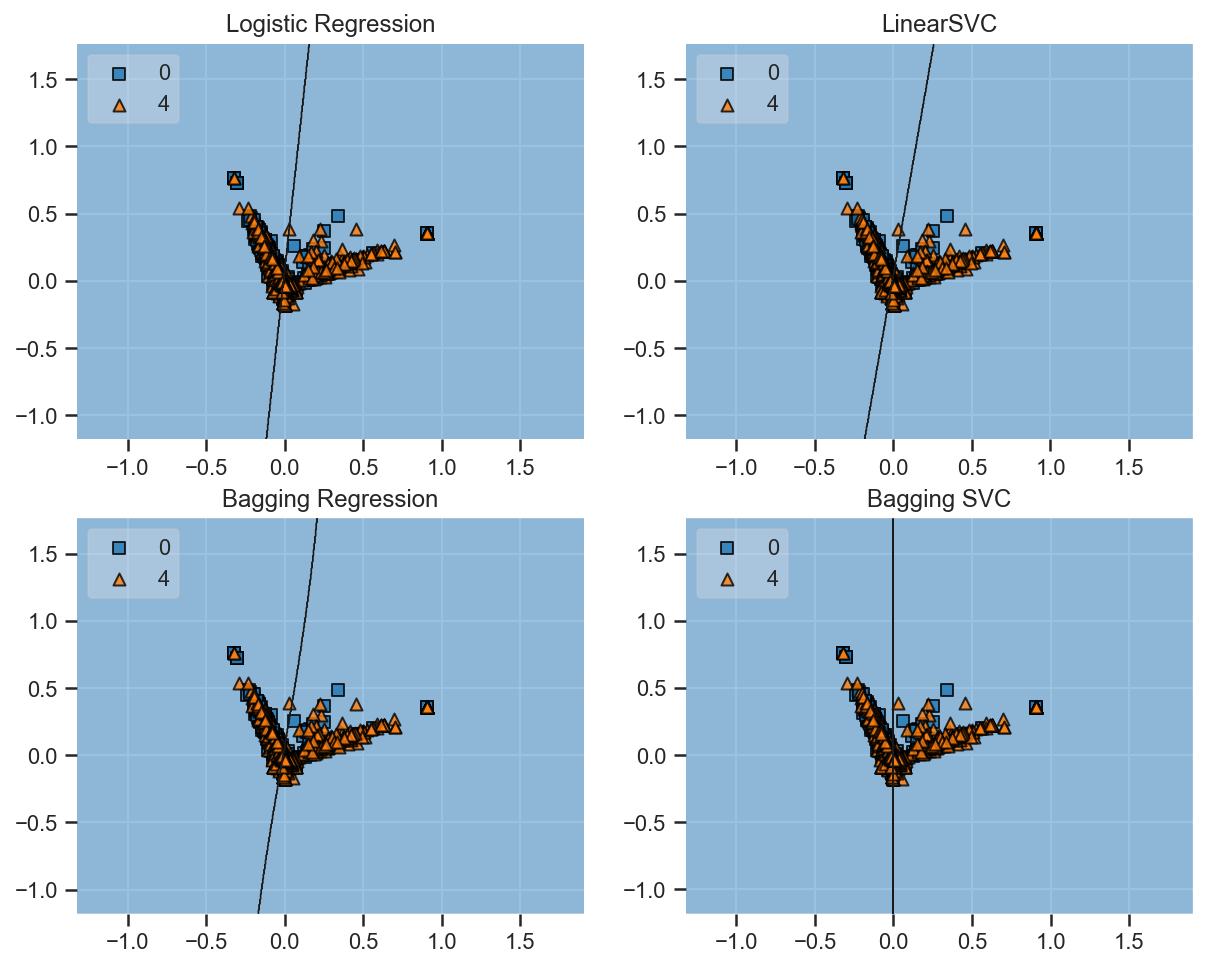

In [114]:
from sklearn.decomposition import PCA

label = ['Logistic Regression', 'LinearSVC', 'Bagging Regression', 'Bagging SVC']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    #clf.fit(X, y)
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    #clf.fit(X_flattened, y)
    #clf.fit(X, y)
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf, legend=2)
    plt.title(label)
    

    #plot_decision_regions(X_train2, y_train, clf=clf, legend=2)

plt.show()

## Much better accuracy with these algorithms! Moved us from the low 60s to the mid 70s.

Also, when we went back and chose more features, and ran everything with more rows of data, we find that we are able to get similar scores for the ensembled models as we did for the standalones. This was an improvement!

# Bagging with Logistic Regression

## Look for ideal ensembling size

In [115]:
#Ensemble Size
# num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,50,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

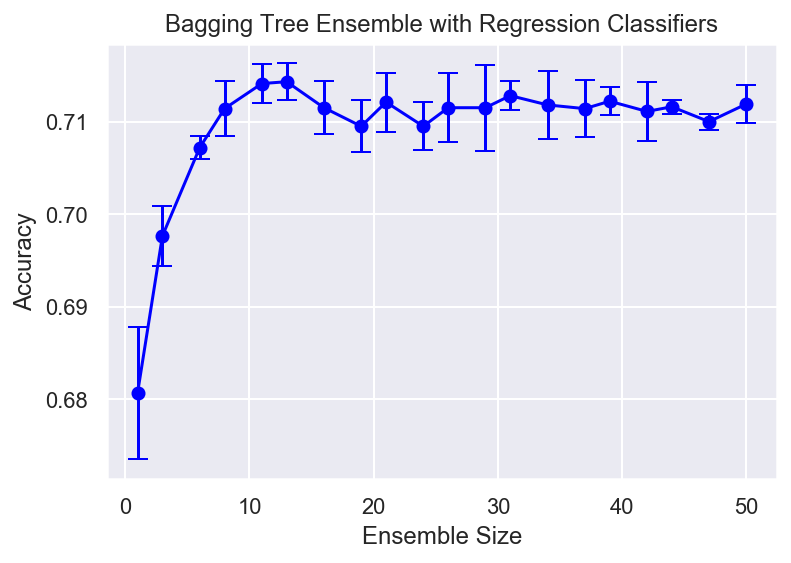

In [116]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
# caps = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble with Regression Classifiers');
plt.show()

## We started using 10 in the ensemble, based on how this graph keeps turning out we increased that to 20.

## Learning Curves for Bagging with Logistic Regression

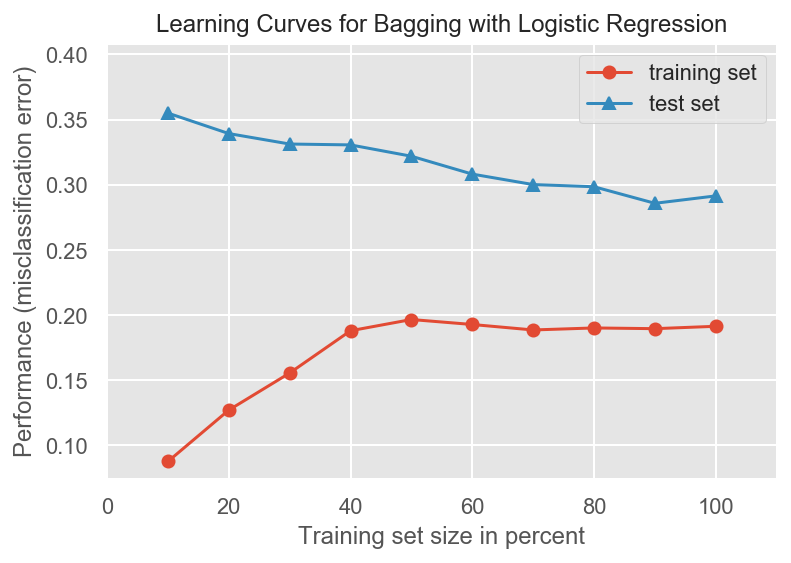

In [117]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.title('Learning Curves for Bagging with Logistic Regression')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of  0.35  on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around  80%  of the training set size.

## Confusion Matrix: Bagging with Regression

RAW CONFUSION MATRIX 

[[ 950  552]
 [ 319 1168]] 

--------------------

Heatmap of Consfusion Matrix:


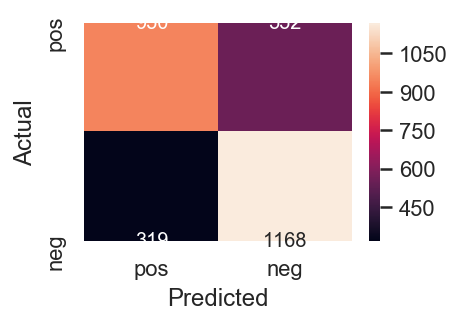

In [118]:
y_pred = bagging1.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Precision, Recall, and F1-Score for Bagging with Regression

In [119]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

              precision    recall  f1-score   support

           0       0.75      0.63      0.69      1502
           4       0.68      0.79      0.73      1487

    accuracy                           0.71      2989
   macro avg       0.71      0.71      0.71      2989
weighted avg       0.71      0.71      0.71      2989



## ROC Curve for Bagging with Regression

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.775

ROC Curve for Bagging Ensemble with Logistic Regression Classifier:


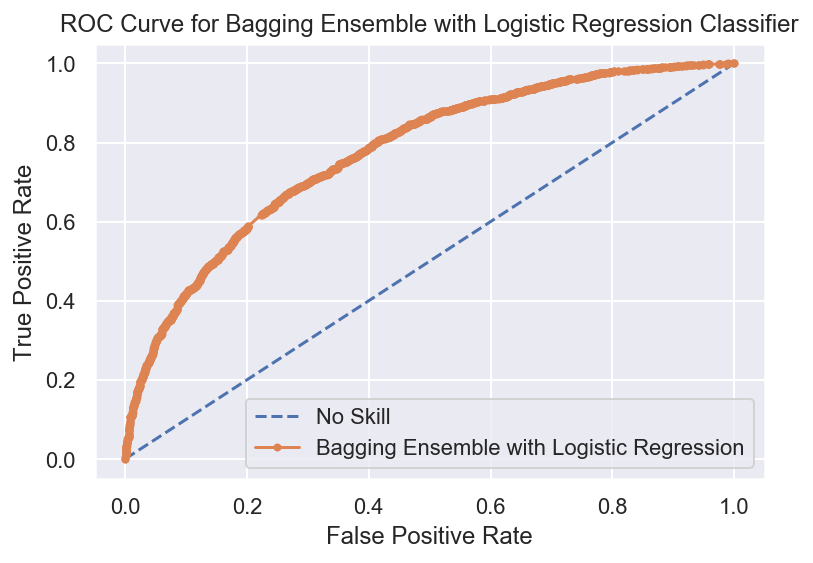

In [120]:
# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
bagging1.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = bagging1.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Bagging Ensemble with Logistic Regression Classifier:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Bagging Ensemble with Logistic Regression')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Bagging Ensemble with Logistic Regression Classifier')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Hmm, not so thrilling?

In one run, we got 0.747 here, compared with 0.750 for straight Logistic Regression. Losing performance with ensemble methods? At least not losing as much as we were earlier...

# Bagging with Linear SVC

### As above, but with Ensembles of Linear SVC classifiers rather than Ensembles of Logistic Regression classifiers.

## Find optimal Ensemble size:

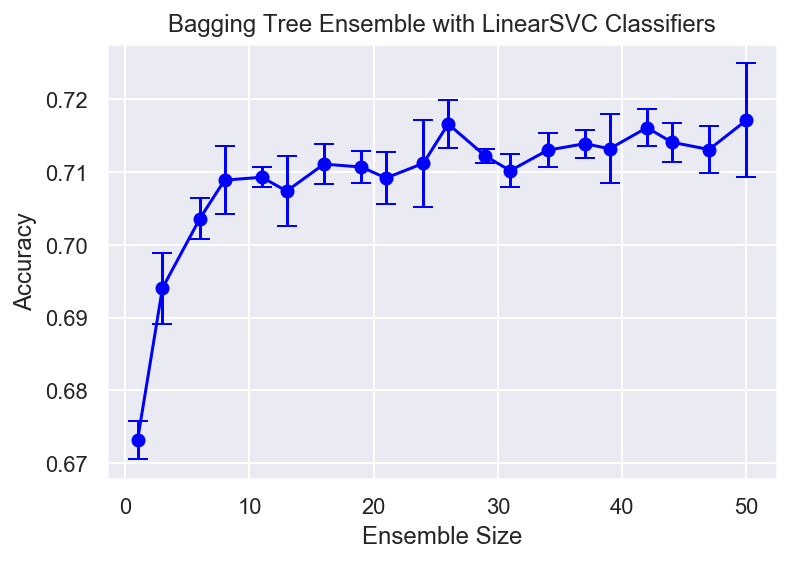

In [121]:
num_est = np.linspace(1,50,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf2, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
# caps = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble with LinearSVC Classifiers');
plt.show()

## Learning Curve for Bagging Tree Ensemble with SVC Classifiers

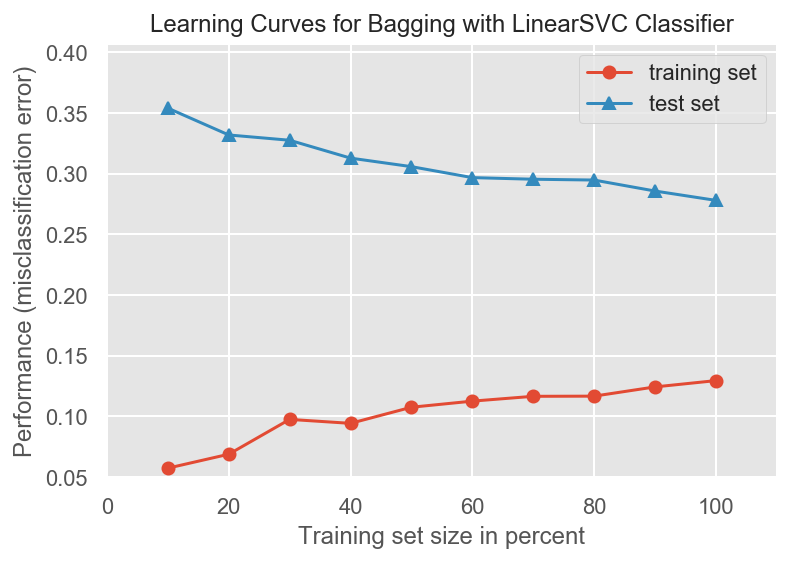

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging2, print_model=False, style='ggplot')
plt.title('Learning Curves for Bagging with LinearSVC Classifier')
plt.show()

## Evaluation Metrics for Bagging with Linear SVC

#### Confusion Matrix, Precision, Recall, and F1-Scores

RAW CONFUSION MATRIX 

[[1000  502]
 [ 329 1158]] 

--------------------

Heatmap of Consfusion Matrix:


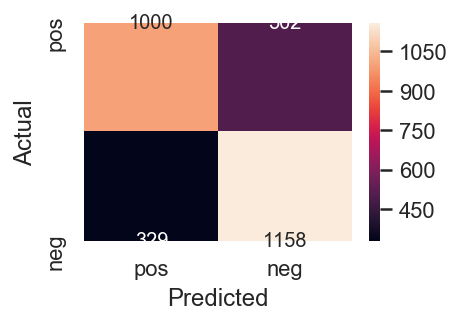

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1502
           4       0.70      0.78      0.74      1487

    accuracy                           0.72      2989
   macro avg       0.73      0.72      0.72      2989
weighted avg       0.73      0.72      0.72      2989



In [123]:
y_pred = bagging2.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

## ROC Curve for Bagging Ensemble with Linear SVC Classifiers

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.756

ROC Curve for Bagging Ensemble with Linear SVC Classifiers:


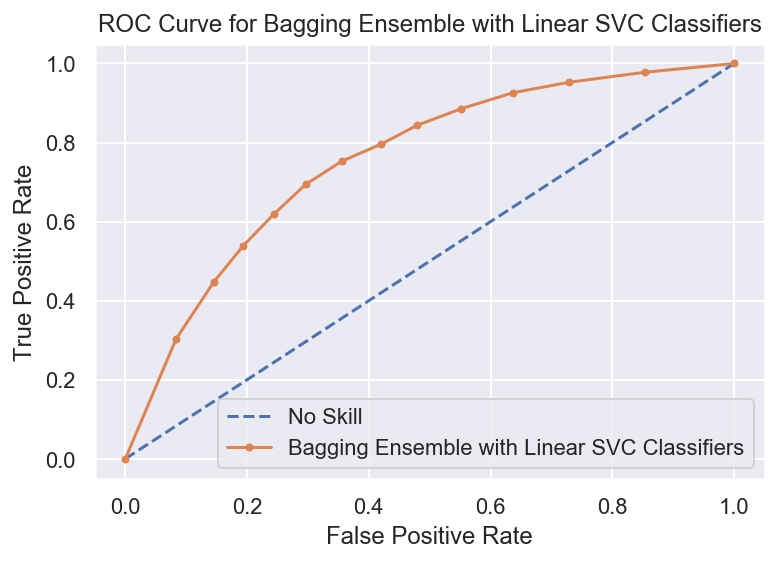

In [124]:
# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
bagging2.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = bagging2.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Bagging Ensemble with Linear SVC Classifiers:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Bagging Ensemble with Linear SVC Classifiers')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Bagging Ensemble with Linear SVC Classifiers')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

----------------------

# Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.

In [125]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [126]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf = LogisticRegression(random_state=0)

num_est = [1, 5, 25, 100]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=5)', 'AdaBoost (n_est=25)', 'AdaBoost (n_est=100)']

In [127]:
len(X)

9962

Accuracy: 0.72 (+/- 0.00) [AdaBoost (n_est=1)]
Accuracy: 0.72 (+/- 0.00) [AdaBoost (n_est=5)]
Accuracy: 0.72 (+/- 0.00) [AdaBoost (n_est=25)]
Accuracy: 0.72 (+/- 0.00) [AdaBoost (n_est=100)]


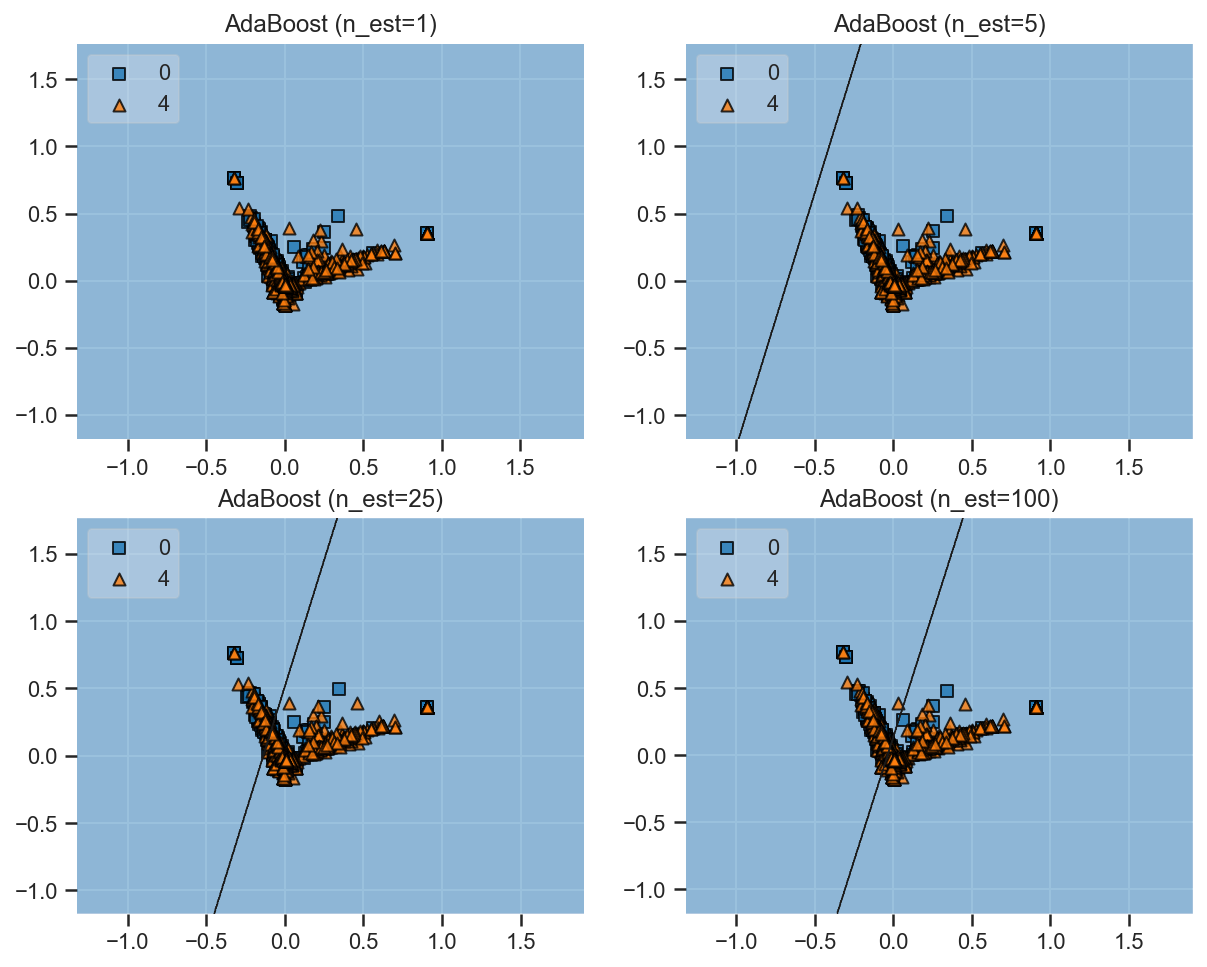

In [128]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    
    
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
    boosting.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each base learner consists of a decision tree with depth $1$, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

## Ensemble Size for AdaBoost with Regression

It appears that a higher number of classifiers in the Ensemble helps - hundreds or more?

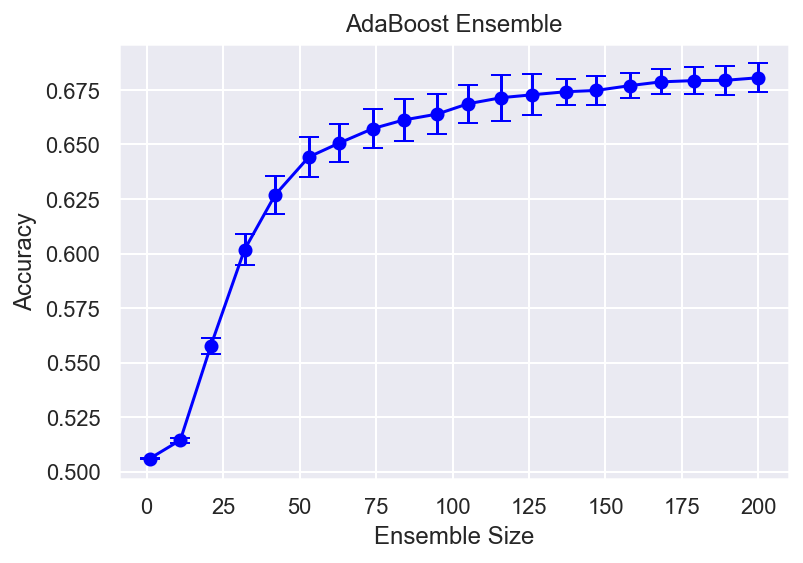

In [129]:
#Ensemble Size
#num_est = map(int, np.linspace(1,100,20))
num_est = np.linspace(1,200,20).astype(int)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

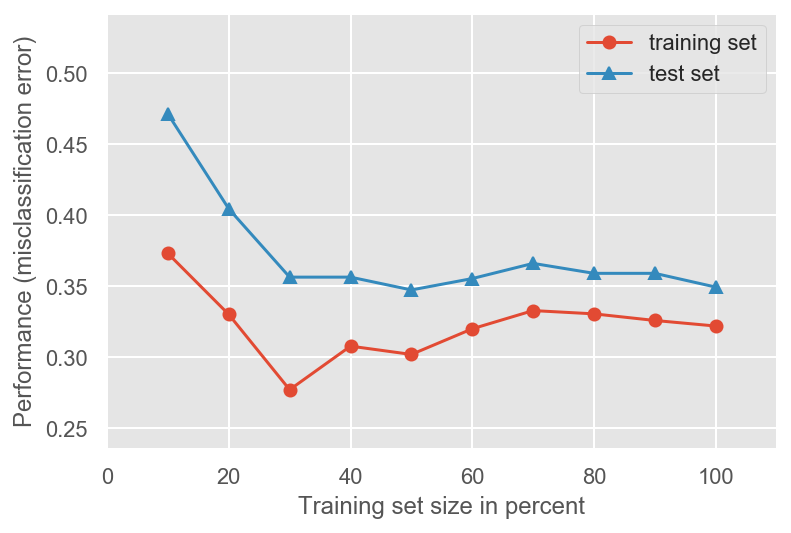

In [130]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=100)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

## Confusion Matrix, F1-Score, etc for Boosting with Regression

RAW CONFUSION MATRIX 

[[ 653  841]
 [ 203 1292]] 

--------------------

Heatmap of Consfusion Matrix:


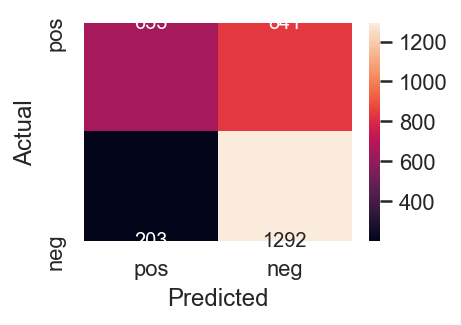

              precision    recall  f1-score   support

           0       0.76      0.44      0.56      1494
           4       0.61      0.86      0.71      1495

    accuracy                           0.65      2989
   macro avg       0.68      0.65      0.63      2989
weighted avg       0.68      0.65      0.63      2989



In [131]:
y_pred = boosting.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

# ROC Curve for Boosting with Regression

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.756

ROC Curve for Boosting with Regression Classifiers:


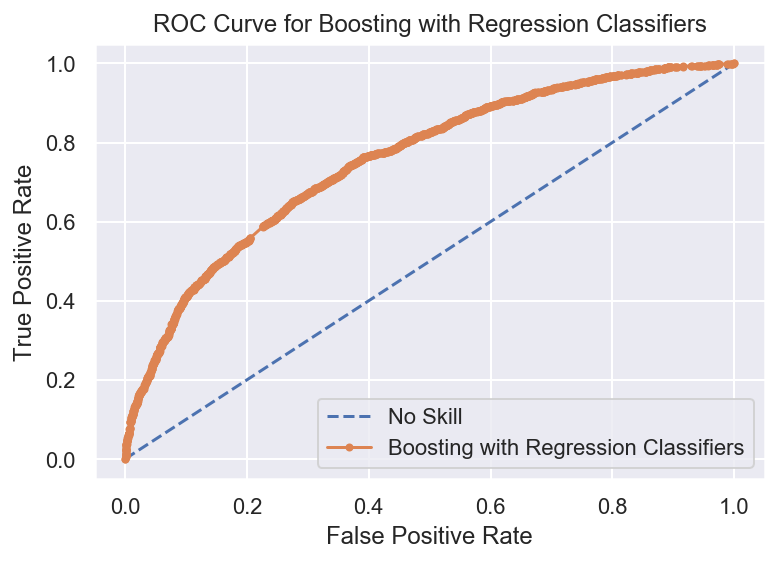

In [132]:
# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
boosting.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = boosting.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Boosting with Regression Classifiers:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Boosting with Regression Classifiers')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Boosting with Regression Classifiers')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

----------------

# Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [133]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [134]:
X = tv_matrix
y = np.array(df_sm['sentiment'])

clf1 = LogisticRegression(random_state=0)
clf2 = LogisticRegression(random_state=0)
clf3 = LogisticRegression(random_state=0)
clf4 = LinearSVC()
clf5 = LinearSVC()
clf6 = LinearSVC()
#clf1 = KNeighborsClassifier(n_neighbors=1)
#clf2 = RandomForestClassifier(random_state=1)
#clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6], 
                          meta_classifier=lr)

Accuracy: 0.56 (+/- 0.01) [Logistic Regression]
Accuracy: 0.55 (+/- 0.01) [Logistic Regression]
Accuracy: 0.55 (+/- 0.01) [Logistic Regression]
Accuracy: 0.55 (+/- 0.01) [LinearSVC]


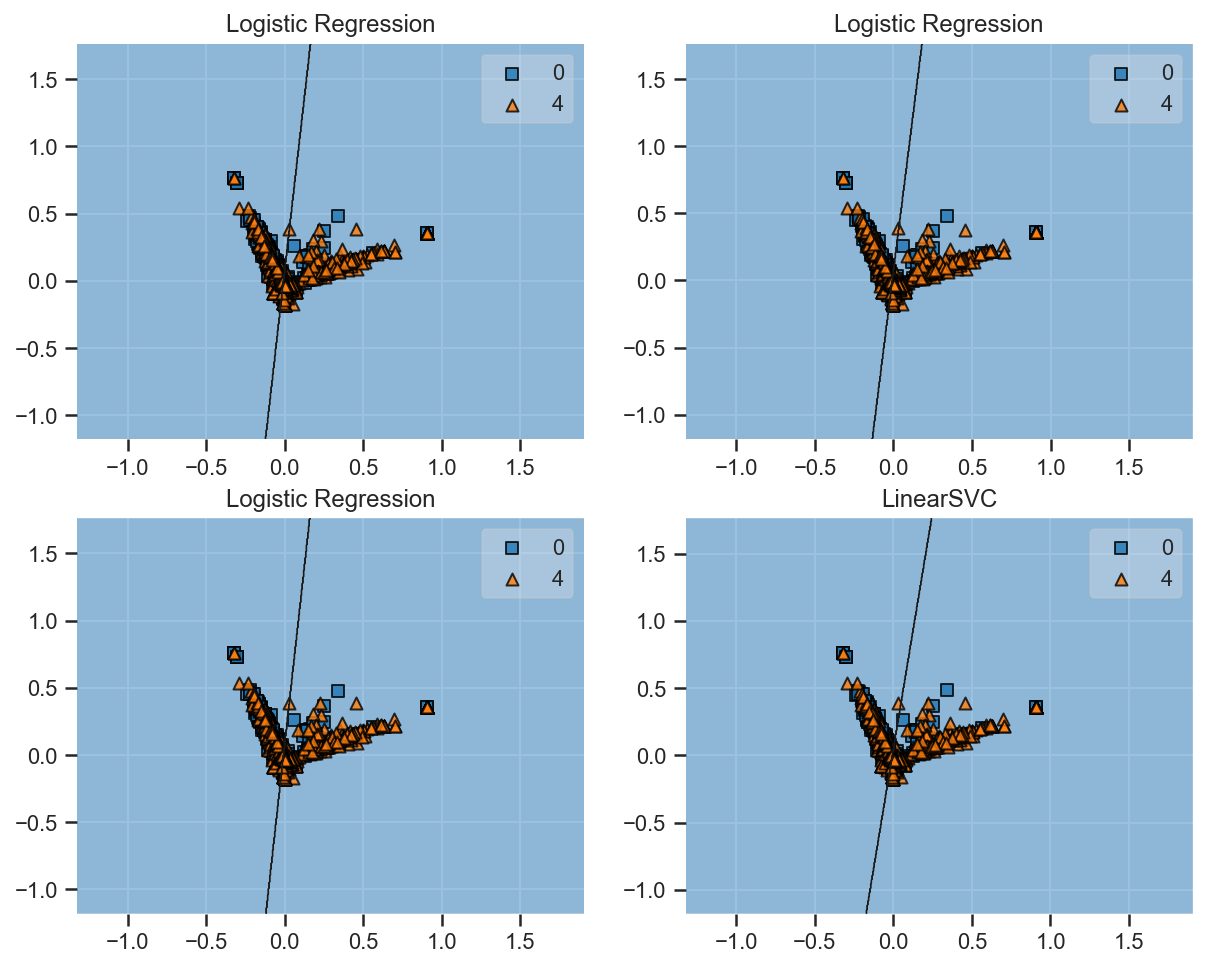

In [135]:
label = ['Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'LinearSVC', 'LinearSVC', 'LinearSVC', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    
    pca = PCA(n_components = 2)
    X_flattened = pca.fit_transform(X)
        
    scores = cross_val_score(clf, X_flattened, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X_flattened, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_flattened, y=y, clf=clf)
    plt.title(label)

plt.show()

The stacking ensemble is illustrated in the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Lostic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

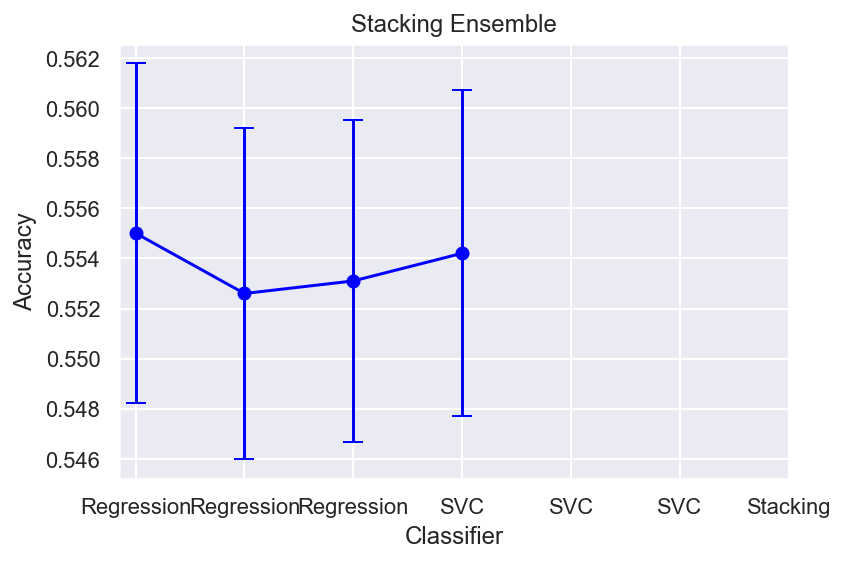

In [136]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(7), ['Regression', 'Regression', 'Regression', 'SVC', 'SVC', 'SVC', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

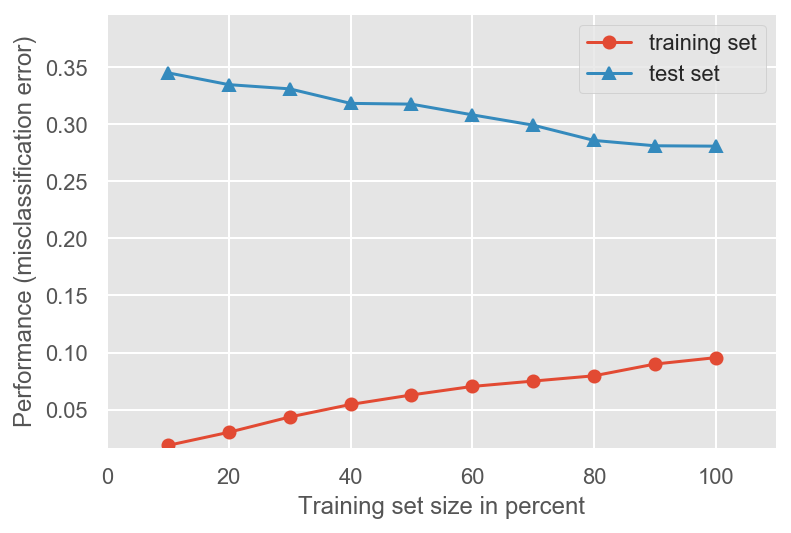

In [137]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

RAW CONFUSION MATRIX 

[[ 988  514]
 [ 325 1162]] 

--------------------

Heatmap of Consfusion Matrix:


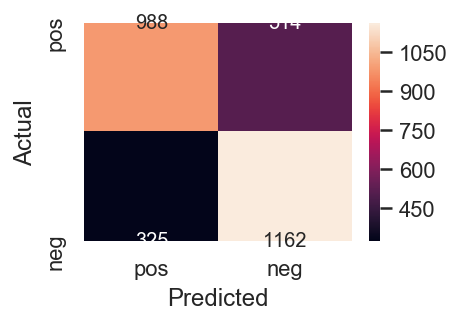

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1502
           4       0.69      0.78      0.73      1487

    accuracy                           0.72      2989
   macro avg       0.72      0.72      0.72      2989
weighted avg       0.72      0.72      0.72      2989



In [138]:
y_pred = sclf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print('RAW CONFUSION MATRIX', '\n')
print(conf_mat, '\n')
print('--------------------\n')
print('Heatmap of Consfusion Matrix:')
fig, ax = plt.subplots(figsize=(3,2))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['pos','neg'], yticklabels=['pos','neg'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=['0','4']))

No Skill: ROC AUC=0.500
LinearSVC: ROC AUC=0.717

ROC Curve for Bagging Ensemble with Linear SVC Classifiers:


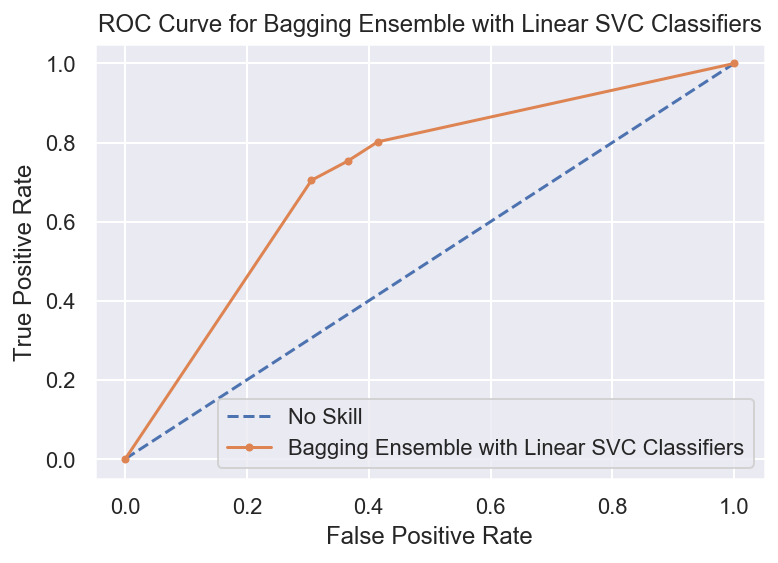

In [139]:
# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
X = tv_matrix
y = df_sm['sentiment']
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = LogisticRegression(solver='lbfgs')

# We use our model as defined above
sclf.fit(trainX, trainy)
# predict probabilities
# use _predict_proba_lr(testX) with SVC
lr_probs = sclf.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LinearSVC: ROC AUC=%.3f' % (lr_auc))
print('\nROC Curve for Bagging Ensemble with Linear SVC Classifiers:')
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label=4)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label=4)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Bagging Ensemble with Linear SVC Classifiers')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Bagging Ensemble with Linear SVC Classifiers')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

End of code for Milestone 2. Please see top of document for more information.

# Summary of Results

## Evaluation Metrics of different classifiers

### TF-IDF Encoding, 3000 rows, 1200 features selected with Extra Trees.

<table><tr><th>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Classifier Type&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Accuracy&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;F1-Score&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;ROC/AUC&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Test Set Errors&nbsp;&nbsp;&nbsp;</th></tr>
    <tr><td>Logistic Regression</td><td>0.69</td><td>0.70</td><td>0.737</td><td>0.17</td></tr>
    <tr><td>LinearSVC</td><td>0.69</td><td>0.70</td><td>0.733</td><td>0.18</td></tr>
    <tr><td>MultinomialNB</td><td>0.69</td><td>0.69</td><td>0.736</td><td>0.33</td></tr>
    <tr><td>Random Forest</td><td>0.64</td><td>0.66</td><td>0.724</td><td>0.35</td></tr>
    <tr><td>Bagging/Regression</td><td>0.68</td><td>0.68</td><td>0.730</td><td>0.31</td></tr>
    <tr><td>Bagging/LinearSVC</td><td>0.69</td><td>0.69</td><td>0.727</td><td>0.32</td></tr>
    <tr><td>Boosting/Regression</td><td>0.68</td><td>0.67</td><td>0.722</td><td>0.34</td></tr>
    <tr><td>Stacking</td><td>0.59</td><td>0.69</td><td>0.652</td><td>0.30</td></tr>
</table>





## Selecting more "features" gets us a trivial increase across the board.

### TF-IDF Encoding, 3000 rows, 2400 features selected with Extra Trees.

<table><tr><th>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Classifier Type&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Accuracy&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;F1-Score&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;ROC/AUC&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Test Set Errors&nbsp;&nbsp;&nbsp;</th></tr>
    <tr><td>Logistic Regression</td><td>0.71</td><td>0.71</td><td>0.757</td><td>0.17</td></tr>
    <tr><td>LinearSVC</td><td>0.71</td><td>0.71</td><td>0.755</td><td>0.16</td></tr>
    <tr><td>MultinomialNB</td><td>0.70</td><td>0.71</td><td>0.745</td><td>0.32</td></tr>
    <tr><td>Random Forest</td><td>0.67</td><td>0.69</td><td>0.733</td><td>0.33</td></tr>
    <tr><td>Bagging/Regression</td><td>0.70</td><td><b>0.72*</b></td><td>0.749</td><td>0.28</td></tr>
    <tr><td>Bagging/LinearSVC</td><td>0.70</td><td><b>0.72*</b></td><td>0.736</td><td>0.28</td></tr>
    <tr><td>Boosting/Regression</td><td>0.70</td><td>0.69</td><td>0.743</td><td>0.31</td></tr>
    <tr><td>Stacking</td><td>0.56</td><td>0.71</td><td>0.67</td><td>0.30</td></tr>
</table>

(starred) - significant because it was the first time I was able to get a better f1-score with an ensemble, than with a standalone classifier.


## More data, more features, minimal improvements

### TF-IDF Encoding, 10,000 rows, 3500 features selected with Extra Trees

<table><tr><th>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Classifier Type&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Accuracy&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;F1-Score&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;ROC/AUC&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Test Set Errors&nbsp;&nbsp;&nbsp;</th></tr>
    <tr><td>Logistic Regression</td><td>0.71</td><td>0.71</td><td>0.780</td><td>0.17</td></tr>
    <tr><td>LinearSVC</td><td>0.71</td><td>0.71</td><td>0.768</td><td>0.16</td></tr>
    <tr><td>MultinomialNB</td><td>0.71</td><td>0.71</td><td>0.766</td><td>0.31</td></tr>
    <tr><td>Random Forest</td><td>0.65</td><td>0.68</td><td>0.761</td><td>0.31</td></tr>
    <tr><td>Bagging/Regression</td><td>0.70</td><td>0.71</td><td>0.775</td><td>0.29</td></tr>
    <tr><td>Bagging/LinearSVC</td><td>0.71</td><td>0.72</td><td>0.756</td><td>0.27</td></tr>
    <tr><td>Boosting/Regression</td><td>0.72</td><td>0.63</td><td>0.756</td><td>0.35</td></tr>
    <tr><td>Stacking</td><td>0.55</td><td>0.72</td><td>0.717</td><td>0.23</td></tr>
</table>


### Blank table for when I run it again

<table><tr><th>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Classifier Type&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Accuracy&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;F1-Score&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;ROC/AUC&nbsp;&nbsp;&nbsp;</th><th>&nbsp;&nbsp;&nbsp;Test Set Errors&nbsp;&nbsp;&nbsp;</th></tr>
    <tr><td>Logistic Regression</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>LinearSVC</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>MultinomialNB</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>Random Forest</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>Bagging/Regression</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>Bagging/LinearSVC</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>Boosting/Regression</td><td></td><td></td><td></td><td></td></tr>
    <tr><td>Stacking</td><td></td><td></td><td></td><td></td></tr>
</table>



---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [140]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [141]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [142]:
#for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
#    print('TEXT:', texts)
#    print('Actual Sentiment:', sentiment)
#    print('Predicted Sentiment polarity:', afn.score(texts))
#    print('-'*60)

In [143]:
# Predict sentiment with Afinn

#sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
#predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [144]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
#meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
#                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [145]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
1043141,4,1957287517,Fri May 29 00:03:19 PDT 2009,NO_QUERY,buwaleed,watching jay leno and dont now if its live or not but i like it,watching jay leno and dont now if its live or not but i like it,watching jay leno dont live like,watch jay leno do not live like,jay leno,,watch live,jay leno watch live,7
461035,0,2174354171,Sun Jun 14 22:22:44 PDT 2009,NO_QUERY,mrmarshalll,@caitlinwashere I never go to shows anymore,I never go to shows anymore,never go shows anymore,never go show anymore,show,,go,show go,4
113302,0,1825766278,Sun May 17 06:46:35 PDT 2009,NO_QUERY,Gallucks,"sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy, sunday lunch before we go away! leave for cyprus on wednesday morning, why is my schedule always jampacked?","sleepy sunday lunch go away leave cyprus wednesday morning , schedule always jampacked ?","sleepy sunday lunch go away leave cyprus wednesday morning , schedule always jampack ?",sleepy sunday lunch cyprus wednesday morning schedule,,go leave jampack,sleepy sunday lunch cyprus wednesday morning schedule go leave jampack,14
166537,0,1961291796,Fri May 29 09:16:34 PDT 2009,NO_QUERY,twitchy67,@unmarketing boo i'm a week late how long u in town for?,boo i'm a week late how long u in town for?,boo im week late long u town,boo -PRON- be week late long u town,boo week u town,,be,boo week u town be,8
716186,0,2259628468,Sat Jun 20 17:54:09 PDT 2009,NO_QUERY,AsMooNy,Just finish studying! ya rb sa3dni &lt;3 8ddami sa3ab noom !! Waiting for alfjur pray..,Just finish studying! ya rb sadni < ddami saab noom !! Waiting for alfjur pray..,finish studying ya rb sadni ddami saab noom !! waiting alfjur pray ..,finish study ya rb sadni ddami saab noom ! ! wait alfjur pray ..,rb sadni ddami saab noom alfjur pray,,finish study wait,rb sadni ddami saab noom alfjur pray finish study wait,14


## Save to database

In [146]:
#df.to_sql('df_sm', con)